In [1]:
import pandas as pd
import pyspark.sql.functions as F
from datetime import datetime
from pyspark.sql.types import *
# from wordcloud import WordCloud, STOPWORDS
from pyspark import StorageLevel

import numpy as np
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
pd.set_option("mode.chained_assignment", None)

In [5]:
# !pip install plotly
# !pip install -U kaleido

In [6]:
# dataviz
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
import kaleido

In [5]:
# spark = SparkSession.builder.getOrCreate()
# TMP_BUCKET = "ai-covid-tmp"
# spark.conf.set("temporaryGcsBucket", TMP_BUCKET)
# spark.sparkContext.setCheckpointDir("hdfs:///tmp/")
# sc = spark.sparkContext

<hr />

<hr />
<hr />
<hr />

In [8]:
# reading super_srag data
super_srag = spark.read.parquet('gs://ai-covid19-datalake/standard/super-srag/super_srag_v2.parquet').persist(StorageLevel.MEMORY_ONLY)
super_srag.limit(2).toPandas()

NU_NOTIFIC CS_SEXO     DT_NASC  AGE_AT_NOTIF  AGE_GROUP  CS_GESTANT  \
0  68719768275       M  1967-01-25            54          7           6   
1  68719899483       M  1959-10-20            61          8           6   

   CS_RACA CS_ETINIA  CS_ESCOL_N SG_UF  CO_MUN_RES SEM_PRI SEM_NOT  \
0        4      None         NaN    BA      290240      19      20   
1        4      None         9.0    BA      292050      19      20   

   DIST_PRI_NOTIFIC  DT_SIN_PRI SG_UF_NOT CO_MUN_NOT SURTO_SG  NOSOCOMIAL  \
0                 7  2021-05-15        BA     291800     None         NaN   
1                 8  2021-05-11        BA     292050     None         2.0   

   AVE_SUINO VACINA HOSPITAL  DIST_PRI_INTERNA  SUPORT_VEN  UTI  \
0        NaN   None        1               NaN         NaN  NaN   
1        2.0   None        1               8.0         3.0  2.0   

  DIST_PRI_ENTUTI CLASSI_OUT CRITERIO EVOLUCAO CLASSI_FIN SYMP_GROUP1  \
0            None       None     None     None       None           9   
1            None       None     None     None       None           3   

  SYMP_GROUP2 SYMP_GROUP3 SYMP_GROUP4  OUTRO_SIN              OUTRO_DES  \
0           3           2           1        NaN                   None   
1           1           3           1        1.0  ASTENIA E INAPETENCIA   

  RF_GROUP1 RF_GROUP2 RF_GROUP3 RF_GROUP4 OBES_IMC OUT_MORBI MORB_DESC  \
0         1         1         1         1     None      None      None   
1         1         1         1         1     None      None      None   

  RAIOX_RES DIST_PRI_RAIOX TOMO_RES DIST_PRI_TOMO  AMOSTRA  TP_AMOSTRA  \
0      None           None     None          None        2         NaN   
1      None           None        6          None        1         1.0   

    DT_COLETA  ...  GMR_PARKS_PERCENT_AVG  \
0        None  ...              -44.62533   
1  2021-05-17  ...              -44.62533   

  GMR_TRANSIT_STATIONS_1WEEK_BEFORE_AVG  \
0                            -25.097436   
1                            -25.097436   

  GMR_GROCERY_AND_PHARMACY_1WEEK_BEFORE_AVG  \
0                                 34.628571   
1                                 34.628571   

  GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_AVG  \
0                                 -20.930314   
1                                 -20.930314   

  GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_AVG  \
0                                0.773764   
1                                0.773764   

  GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_AVG GMR_PARKS_PERCENT_1WEEK_BEFORE_AVG  \
0                                  6.81768                         -44.472296   
1                                  6.81768                         -44.472296   

  GMR_TRANSIT_STATIONS_2WEEKS_AVG GMR_GROCERY_AND_PHARMACY_2WEEKS_AVG  \
0                      -31.233161                           17.257009   
1                      -31.233161                           17.257009   

  GMR_RETAIL_AND_RECREATION_2WEEKS_AVG GMR_WORKPLACES_PERCENT_2WEEKS_AVG  \
0                           -30.477193                         -4.605239   
1                           -30.477193                         -4.605239   

  GMR_RESIDENTIAL_PERCENT_2WEEKS_AVG GMR_PARKS_PERCENT_2WEEKS_AVG  \
0                           8.130556                   -46.526854   
1                           8.130556                   -46.526854   

  INMET_TEMP_C_AVG INMET_RELATIVE_AIR_HUMIDITY_AVG INMET_DAILY_PRECIPT_AVG  \
0        22.265185                       71.299468                1.115789   
1        22.265185                       71.299468                1.115789   

  INMET_TEMP_C_1WEEK_BEFORE_AVG INMET_RELATIVE_AIR_HUMIDITY_1WEEK_BEFORE_AVG  \
0                     23.258355                                    74.984254   
1                     23.258355                                    74.984254   

  INMET_DAILY_PRECIPT_1WEEK_BEFORE_AVG INMET_TEMP_C_2WEEKS_BEFORE_AVG  \
0                                 2.16                      24.092008   
1                            

<hr />
<hr />
<hr />

In [10]:
states = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ']

In [11]:
# pd_ba_ss['SS_NOTFIC_COUNT_BA'] = pd_ba_ss['SS_NOTFIC_COUNT_BA']/10

In [73]:
pd_ba_ss = super_srag.filter((F.col('SG_UF_NOT')=='BA') & (F.year(F.col('DT_SIN_PRI')) == 2021)).groupBy('EPI_WEEK_YEAR')\
                                                                                         .agg({'GMR_RESIDENTIAL_PERCENT_AVG':'avg',
                                                                                               'INMET_RELATIVE_AIR_HUMIDITY_AVG':'avg',
                                                                                               'NU_NOTIFIC':'count'})\
                                                                                         .orderBy('EPI_WEEK_YEAR')\
                                                                                         .withColumnRenamed('avg(GMR_RESIDENTIAL_PERCENT_AVG)', 'GMR_RESID_PERC_AVG_BA')\
                                                                                         .withColumnRenamed('avg(INMET_RELATIVE_AIR_HUMIDITY_AVG)', 'INMET_REL_AIR_HUM_AVG_BA')\
                                                                                         .withColumnRenamed('count(NU_NOTIFIC)', 'SS_NOTFIC_COUNT_BA')\
                                                                                         .toPandas()
pd_ba_ss['SS_NOTFIC_COUNT_BA'] = pd_ba_ss['SS_NOTFIC_COUNT_BA']/10

In [74]:
# plotting
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=pd_ba_ss['EPI_WEEK_YEAR'].tolist(), y=pd_ba_ss['GMR_RESID_PERC_AVG_BA'].tolist(), name='isolation avg',
                         line=dict(color='firebrick', width=4, shape='spline')))

fig.add_trace(go.Scatter(x=pd_ba_ss['EPI_WEEK_YEAR'].tolist(), y=pd_ba_ss['INMET_REL_AIR_HUM_AVG_BA'].tolist(), name='air humid. avg',
                         line=dict(color='green', width=4, shape='spline')))

fig.add_trace(go.Scatter(x=pd_ba_ss['EPI_WEEK_YEAR'].tolist(), y=pd_ba_ss['SS_NOTFIC_COUNT_BA'].tolist(), name='N cases x 10',
                         line=dict(color='blue', width=4, shape='spline')))

# Edit the layout
fig.update_layout(title='notifications | air humidity avg | isolation avg - BA 2021',
                  font=dict(
                            family="Courier New, monospace",
                            size=14,
                            color="#7f7f7f"
                            ),
                   xaxis_title='epidemiological week',
                   yaxis_title='N'
                 )

fig.update_layout(margin=dict(l=20, r=20, t=80, b=20),
                  width=1000
                 )

fig.update_layout(yaxis_range=[0,400])


fig.write_image("ba_gmr_inmet_test_2021.png")
# fig.show()

In [80]:
pd_ba_ss_2w = super_srag.filter((F.col('SG_UF_NOT')=='BA') & (F.year(F.col('DT_SIN_PRI')) == 2021)).groupBy('EPI_WEEK_YEAR')\
                                                                                         .agg({'GMR_RESIDENTIAL_PERCENT_2WEEKS_AVG':'avg',
                                                                                               'INMET_RELATIVE_AIR_HUMIDITY_2WEEKS_BEFORE_AVG':'avg',
                                                                                               'NU_NOTIFIC':'count'})\
                                                                                         .orderBy('EPI_WEEK_YEAR')\
                                                                                         .withColumnRenamed('avg(GMR_RESIDENTIAL_PERCENT_2WEEKS_AVG)', 'GMR_RESID_PERC_AVG_2W_BA')\
                                                                                         .withColumnRenamed('avg(INMET_RELATIVE_AIR_HUMIDITY_2WEEKS_BEFORE_AVG)', 'INMET_REL_AIR_HUM_AVG_2W_BA')\
                                                                                         .withColumnRenamed('count(NU_NOTIFIC)', 'SS_NOTFIC_COUNT_BA')\
                                                                                         .toPandas()
pd_ba_ss_2w['SS_NOTFIC_COUNT_BA'] = pd_ba_ss_2w['SS_NOTFIC_COUNT_BA']/10

In [81]:
# plotting
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=pd_ba_ss_2w['EPI_WEEK_YEAR'].tolist(), y=pd_ba_ss_2w['GMR_RESID_PERC_AVG_2W_BA'].tolist(), name='isolation avg 2w before',
                         line=dict(color='firebrick', width=4, shape='spline')))

fig.add_trace(go.Scatter(x=pd_ba_ss_2w['EPI_WEEK_YEAR'].tolist(), y=pd_ba_ss_2w['INMET_REL_AIR_HUM_AVG_2W_BA'].tolist(), name='air humid. avg 2w before',
                         line=dict(color='green', width=4, shape='spline')))

fig.add_trace(go.Scatter(x=pd_ba_ss_2w['EPI_WEEK_YEAR'].tolist(), y=pd_ba_ss_2w['SS_NOTFIC_COUNT_BA'].tolist(), name='N cases x 10',
                         line=dict(color='blue', width=4, shape='spline')))

# Edit the layout
fig.update_layout(title='notifications | air humidity avg | isolation avg - BA 2021',
                  font=dict(
                            family="Courier New, monospace",
                            size=14,
                            color="#7f7f7f"
                            ),
                   xaxis_title='epidemiological week',
                   yaxis_title='N'
                 )

fig.update_layout(margin=dict(l=20, r=20, t=80, b=20),
                  width=1000
                 )

fig.update_layout(yaxis_range=[0,400])

fig.write_image("ba_gmr_inmet_test_2w_2021.png")
# fig.show()

<hr />
<hr />
<hr />

In [11]:
# 
super_srag.groupBy(['AGE_GROUP',F.year('DT_SIN_PRI')]).count().orderBy('AGE_GROUP').show(50)

+---------+----------------+------+
|AGE_GROUP|year(DT_SIN_PRI)| count|
+---------+----------------+------+
|        1|            2019| 14470|
|        1|            2018|    20|
|        1|            2020| 23337|
|        1|            2021| 19780|
|        2|            2021| 19021|
|        2|            2020| 32597|
|        2|            2018|    18|
|        2|            2019|  9853|
|        3|            2018|     7|
|        3|            2020| 34120|
|        3|            2021| 14160|
|        3|            2019|  3790|
|        4|            2020| 53775|
|        4|            2019|  2455|
|        4|            2021| 32991|
|        4|            2018|     2|
|        5|            2020|104509|
|        5|            2018|     6|
|        5|            2021| 84869|
|        5|            2019|  2900|
|        6|            2021|129804|
|        6|            2020|143173|
|        6|            2019|  2755|
|        6|            2018|     3|
|        7|            2018|

In [23]:
super_srag.filter(F.year('DT_SIN_PRI') == 2019).groupBy(F.year('DT_SIN_PRI')).count().show()

+----------------+-----+
|year(DT_SIN_PRI)|count|
+----------------+-----+
|            2019|48597|
+----------------+-----+



In [ ]:
super_srag.filter(F.year('DT_SIN_PRI') == 2019).

In [82]:
df_2019 = super_srag.filter(F.year('DT_SIN_PRI') == 2019).select(['DT_SIN_PRI', 'EVOLUCAO', 'AGE_GROUP'])\
            .groupBy([F.month('DT_SIN_PRI'), 'EVOLUCAO', 'AGE_GROUP']).count().orderBy(['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP']).toPandas()
df_2019 = df_2019.fillna('NULO')

In [83]:
df_2020 = super_srag.filter(F.year('DT_SIN_PRI') == 2020).select(['DT_SIN_PRI', 'EVOLUCAO', 'AGE_GROUP'])\
            .groupBy([F.month('DT_SIN_PRI'), 'EVOLUCAO', 'AGE_GROUP']).count().orderBy(['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP']).toPandas()
df_2020 = df_2020.fillna('NULO')

In [84]:
df_2021 = super_srag.filter(F.year('DT_SIN_PRI') == 2021).select(['DT_SIN_PRI', 'EVOLUCAO', 'AGE_GROUP'])\
            .groupBy([F.month('DT_SIN_PRI'), 'EVOLUCAO', 'AGE_GROUP']).count().orderBy(['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP']).toPandas()
df_2021 = df_2021.fillna('NULO')

In [85]:
df_2019['AGE_GROUP'] = df_2019['AGE_GROUP'].replace(1, '< 1')
df_2019['AGE_GROUP'] = df_2019['AGE_GROUP'].replace(2, '1a5')
df_2019['AGE_GROUP'] = df_2019['AGE_GROUP'].replace(3, '6a19')
df_2019['AGE_GROUP'] = df_2019['AGE_GROUP'].replace(4, '20a29')
df_2019['AGE_GROUP'] = df_2019['AGE_GROUP'].replace(5, '30a39')
df_2019['AGE_GROUP'] = df_2019['AGE_GROUP'].replace(6, '40 a 49')
df_2019['AGE_GROUP'] = df_2019['AGE_GROUP'].replace(7, '50 a 59')
df_2019['AGE_GROUP'] = df_2019['AGE_GROUP'].replace(8, '60 a 69')
df_2019['AGE_GROUP'] = df_2019['AGE_GROUP'].replace(9, '70 a 79')
df_2019['AGE_GROUP'] = df_2019['AGE_GROUP'].replace(10, '80 a 89')
df_2019['AGE_GROUP'] = df_2019['AGE_GROUP'].replace(11, '90+')
df_2019['AGE_GROUP'] = df_2019['AGE_GROUP'].replace(12, 'NULO')

In [86]:
df_2020['AGE_GROUP'] = df_2020['AGE_GROUP'].replace(1, '< 1')
df_2020['AGE_GROUP'] = df_2020['AGE_GROUP'].replace(2, '1a5')
df_2020['AGE_GROUP'] = df_2020['AGE_GROUP'].replace(3, '6a19')
df_2020['AGE_GROUP'] = df_2020['AGE_GROUP'].replace(4, '20a29')
df_2020['AGE_GROUP'] = df_2020['AGE_GROUP'].replace(5, '30a39')
df_2020['AGE_GROUP'] = df_2020['AGE_GROUP'].replace(6, '40 a 49')
df_2020['AGE_GROUP'] = df_2020['AGE_GROUP'].replace(7, '50 a 59')
df_2020['AGE_GROUP'] = df_2020['AGE_GROUP'].replace(8, '60 a 69')
df_2020['AGE_GROUP'] = df_2020['AGE_GROUP'].replace(9, '70 a 79')
df_2020['AGE_GROUP'] = df_2020['AGE_GROUP'].replace(10, '80 a 89')
df_2020['AGE_GROUP'] = df_2020['AGE_GROUP'].replace(11, '90+')
df_2020['AGE_GROUP'] = df_2020['AGE_GROUP'].replace(12, 'NULO')

In [87]:
df_2021['AGE_GROUP'] = df_2021['AGE_GROUP'].replace(1, '< 1')
df_2021['AGE_GROUP'] = df_2021['AGE_GROUP'].replace(2, '1a5')
df_2021['AGE_GROUP'] = df_2021['AGE_GROUP'].replace(3, '6a19')
df_2021['AGE_GROUP'] = df_2021['AGE_GROUP'].replace(4, '20a29')
df_2021['AGE_GROUP'] = df_2021['AGE_GROUP'].replace(5, '30a39')
df_2021['AGE_GROUP'] = df_2021['AGE_GROUP'].replace(6, '40 a 49')
df_2021['AGE_GROUP'] = df_2021['AGE_GROUP'].replace(7, '50 a 59')
df_2021['AGE_GROUP'] = df_2021['AGE_GROUP'].replace(8, '60 a 69')
df_2021['AGE_GROUP'] = df_2021['AGE_GROUP'].replace(9, '70 a 79')
df_2021['AGE_GROUP'] = df_2021['AGE_GROUP'].replace(10, '80 a 89')
df_2021['AGE_GROUP'] = df_2021['AGE_GROUP'].replace(11, '90+')
df_2021['AGE_GROUP'] = df_2021['AGE_GROUP'].replace(12, 'NULO')

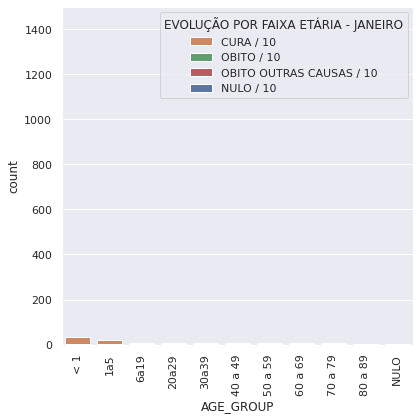

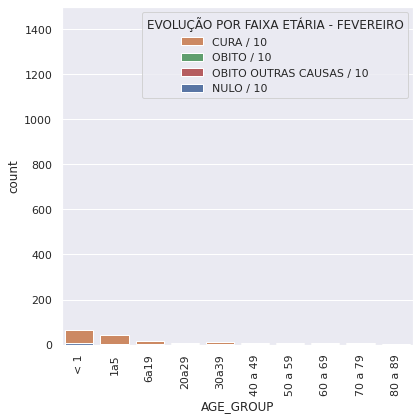

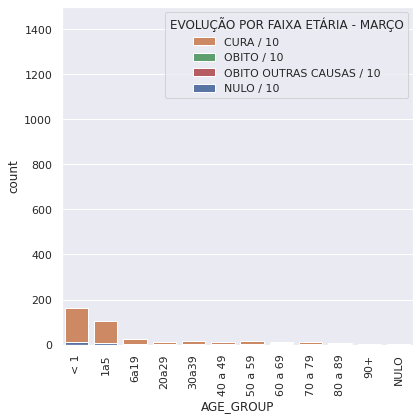

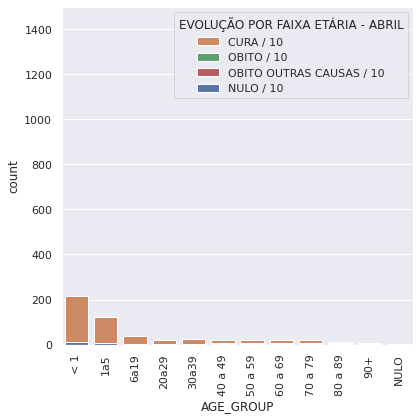

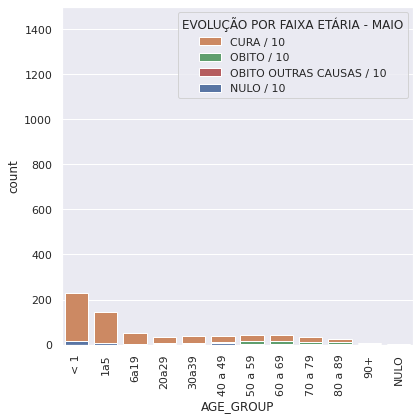

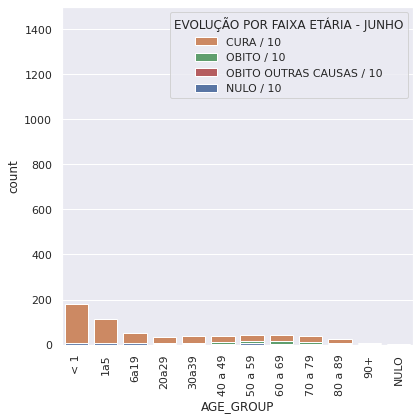

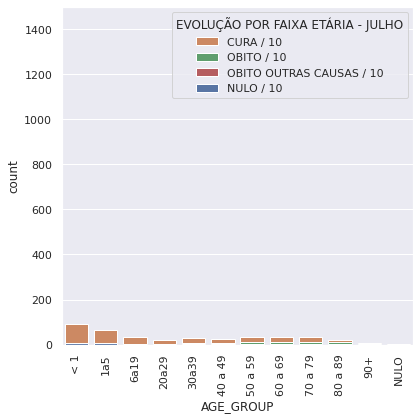

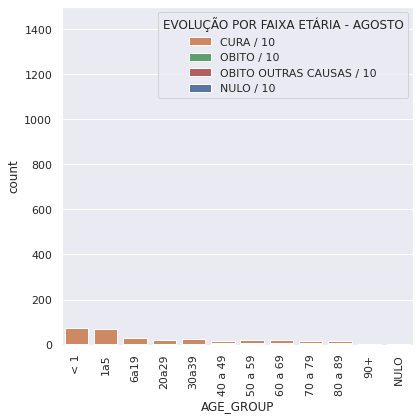

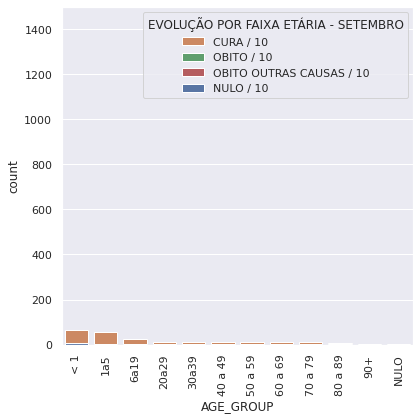

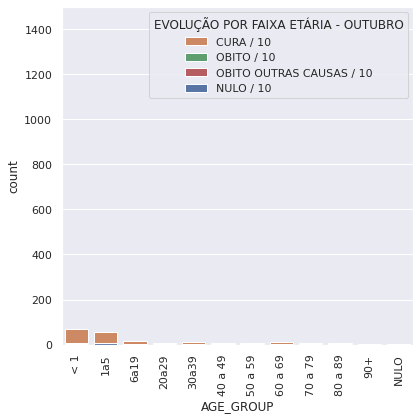

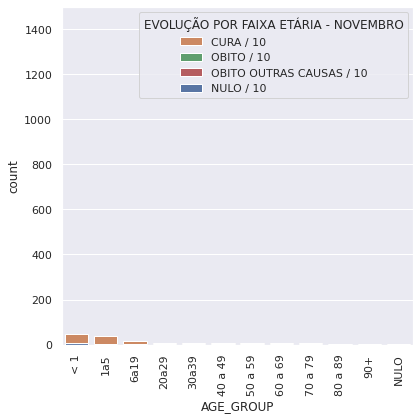

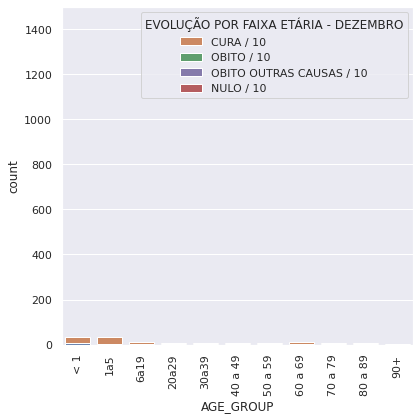

In [34]:
# set plot style: grey grid in the background:
sns.set(style="darkgrid")

unique = df_2019["EVOLUCAO"].append(df_2019["AGE_GROUP"]).unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
palette.update({"Total":"k"})

months = {1:'JANEIRO', 2:'FEVEREIRO', 3:'MARÇO', 4:'ABRIL', 5:'MAIO', 6:'JUNHO',
          7:'JULHO', 8:'AGOSTO', 9:'SETEMBRO', 10:'OUTUBRO', 11:'NOVEMBRO', 12:'DEZEMBRO'}

for month in months:

    # set the figure size
    plt.figure(figsize=(6, 6))
    
    evolutions_cat = {'1': 'CURA', '2': 'ÓBITO', '3': 'ÓBITO OUTRAS CAUSA', '9': 'IGNORADO', 'NULO': 'NULO'}

    data = df_2019[(df_2019['month(DT_SIN_PRI)'] == month) & (df_2019['EVOLUCAO'] == '1')]
    data.loc[:,['count']] = data['count']/10
    
    if len(data) > 0:
        bar1 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, ci=None, palette=palette)
        leg_bar1 = mpatches.Patch(color='darkblue', label='CURA')
        bar1.set(ylim=(0, 1500))

    data = df_2019[(df_2019['month(DT_SIN_PRI)'] == month) & (df_2019['EVOLUCAO'] == '2')]  
    data.loc[:,['count']] = data['count']/10
    
    if len(data) > 0:
        bar2 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, estimator=sum, ci=None, palette=palette)
        leg_bar2 = mpatches.Patch(color='darkblue' ,label='ÓBITO')
        bar2.set(ylim=(0, 1500))

    data = df_2019[(df_2019['month(DT_SIN_PRI)'] == month) & (df_2019['EVOLUCAO'] == '3')]
    data.loc[:,['count']] = data['count']/10
    
    if len(data) > 0:
        bar3 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, estimator=sum, ci=None, palette=palette)
        leg_bar3 = mpatches.Patch(color='darkblue', label='ÓBITO OUTRAS CAUSAS')
        bar3.set(ylim=(0, 1500))

    data = df_2019[(df_2019['month(DT_SIN_PRI)'] == month) & (df_2019['EVOLUCAO'] == '9')]
    data.loc[:,['count']] = data['count']/10
    
    if len(data) > 0:
        bar4 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, estimator=sum, ci=None, palette=palette)
        leg_bar4 = mpatches.Patch(color='darkblue', label='IGNORADO')
        bar4.set(ylim=(0, 1500))

    data = df_2019[(df_2019['month(DT_SIN_PRI)'] == month) & (df_2019['EVOLUCAO'] == 'NULO')]
    data.loc[:,['count']] = data['count']/10
    
    if len(data) > 0:
        bar5 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, estimator=sum, ci=None, palette=palette)
        leg_bar5 = mpatches.Patch(color='darkblue', label='NULO')
        bar5.set(ylim=(0, 1500))

    plt.legend(title='EVOLUÇÃO POR FAIXA ETÁRIA - ' + months[month], loc='upper right', labels=['CURA / 10', 'OBITO / 10', 'OBITO OUTRAS CAUSAS / 10', 'NULO / 10'])
    plt.xticks(rotation='vertical')
    plt.tight_layout()

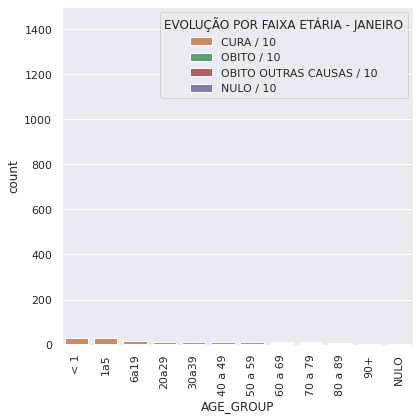

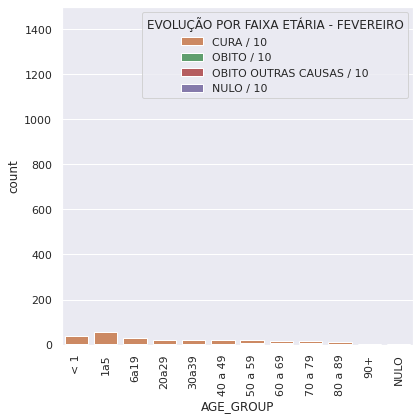

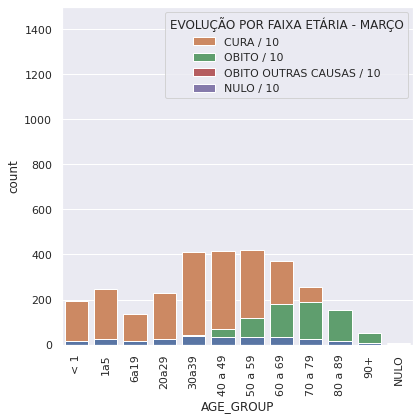

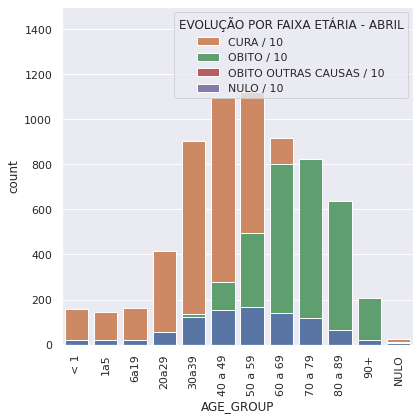

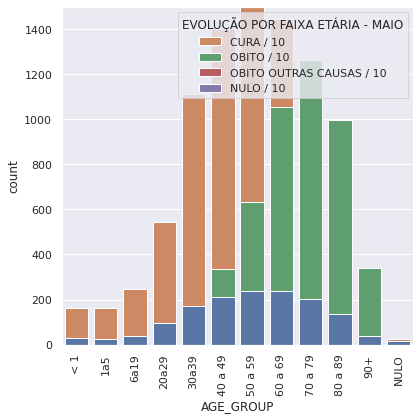

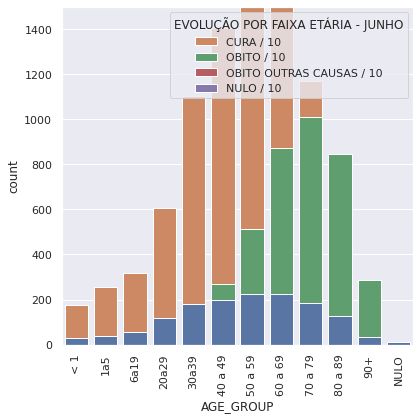

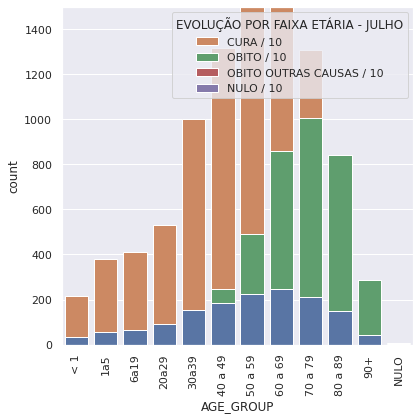

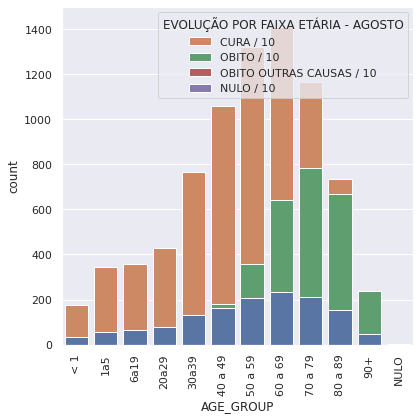

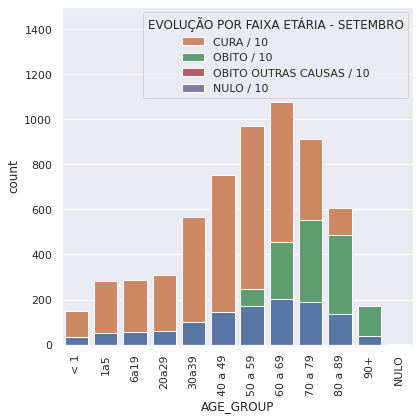

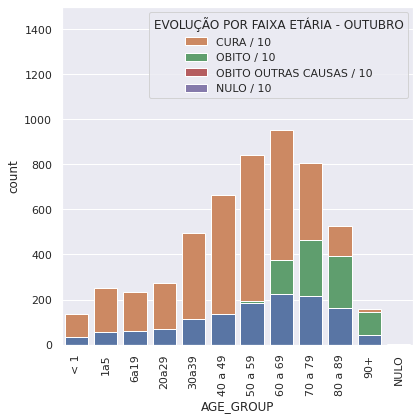

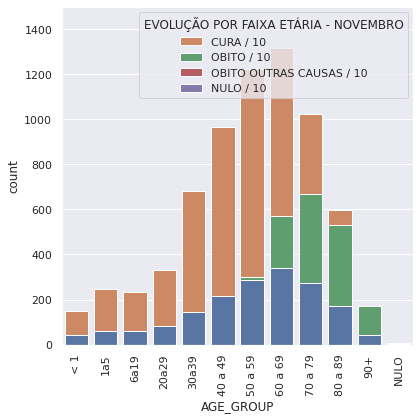

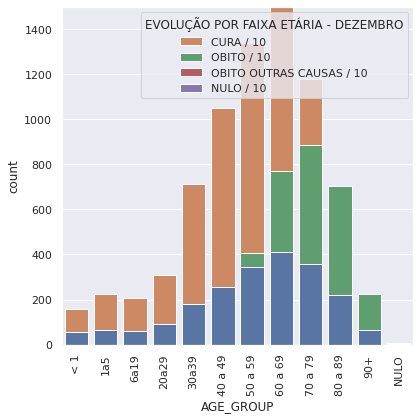

In [35]:
# set plot style: grey grid in the background:
sns.set(style="darkgrid")

unique = df_2020["EVOLUCAO"].append(df_2020["AGE_GROUP"]).unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
palette.update({"Total":"k"})

months = {1:'JANEIRO', 2:'FEVEREIRO', 3:'MARÇO', 4:'ABRIL', 5:'MAIO', 6:'JUNHO',
          7:'JULHO', 8:'AGOSTO', 9:'SETEMBRO', 10:'OUTUBRO', 11:'NOVEMBRO', 12:'DEZEMBRO'}

for month in months:

    # set the figure size
    plt.figure(figsize=(6, 6))
    
    evolutions_cat = {'1': 'CURA', '2': 'ÓBITO', '3': 'ÓBITO OUTRAS CAUSA', '9': 'IGNORADO', 'NULO': 'NULO'}

    data = df_2020[(df_2020['month(DT_SIN_PRI)'] == month) & (df_2020['EVOLUCAO'] == '1')]
    data.loc[:,['count']] = data['count']/10
    
    if len(data) > 0:
        bar1 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, ci=None, palette=palette)
        leg_bar1 = mpatches.Patch(color='darkblue', label='CURA')
        bar1.set(ylim=(0, 1500))

    data = df_2020[(df_2020['month(DT_SIN_PRI)'] == month) & (df_2020['EVOLUCAO'] == '2')]
    data.loc[:,['count']] = data['count']/10
    
    if len(data) > 0:
        bar2 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, estimator=sum, ci=None, palette=palette)
        leg_bar2 = mpatches.Patch(color='darkblue' ,label='ÓBITO')
        bar2.set(ylim=(0, 1500))

    data = df_2020[(df_2020['month(DT_SIN_PRI)'] == month) & (df_2020['EVOLUCAO'] == '3')]
    data.loc[:,['count']] = data['count']/10
    
    if len(data) > 0:
        bar3 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, estimator=sum, ci=None, palette=palette)
        leg_bar3 = mpatches.Patch(color='darkblue', label='ÓBITO OUTRAS CAUSAS')
        bar3.set(ylim=(0, 1500))

    data = df_2020[(df_2020['month(DT_SIN_PRI)'] == month) & (df_2020['EVOLUCAO'] == '9')]
    data.loc[:,['count']] = data['count']/10
    
    if len(data) > 0:
        bar4 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, estimator=sum, ci=None, palette=palette)
        leg_bar4 = mpatches.Patch(color='darkblue', label='IGNORADO')
        bar4.set(ylim=(0, 1500))

    data = df_2020[(df_2020['month(DT_SIN_PRI)'] == month) & (df_2020['EVOLUCAO'] == 'NULO')]
    data.loc[:,['count']] = data['count']/10
    
    if len(data) > 0:
        bar5 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, estimator=sum, ci=None, palette=palette)
        leg_bar5 = mpatches.Patch(color='darkblue', label='NULO')
        bar5.set(ylim=(0, 1500))

    plt.legend(title='EVOLUÇÃO POR FAIXA ETÁRIA - ' + months[month], loc='upper right', labels=['CURA / 10', 'OBITO / 10', 'OBITO OUTRAS CAUSAS / 10', 'NULO / 10'])
    plt.xticks(rotation='vertical')
    plt.tight_layout()

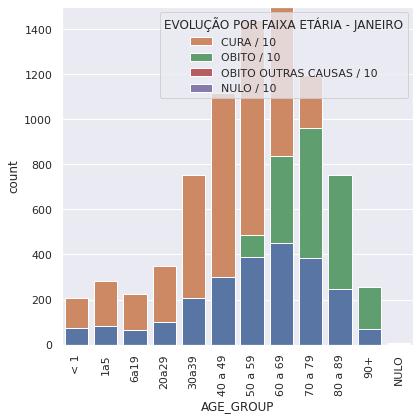

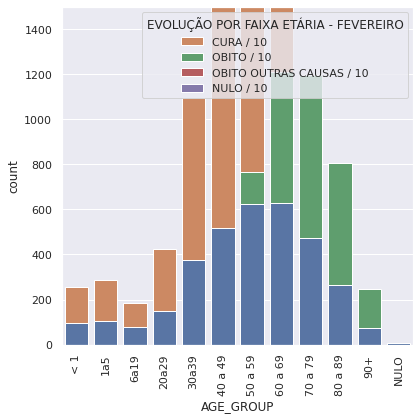

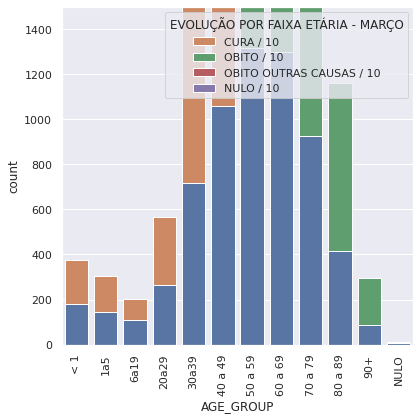

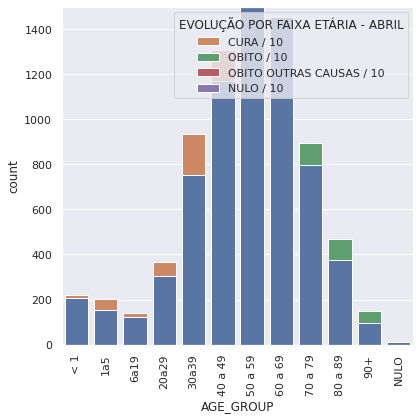

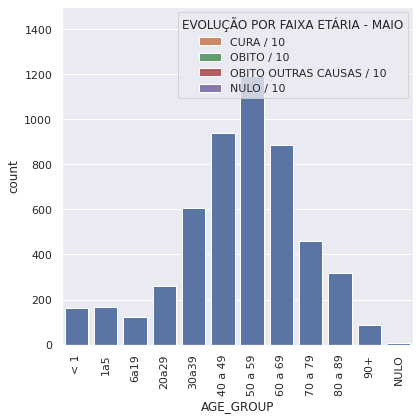

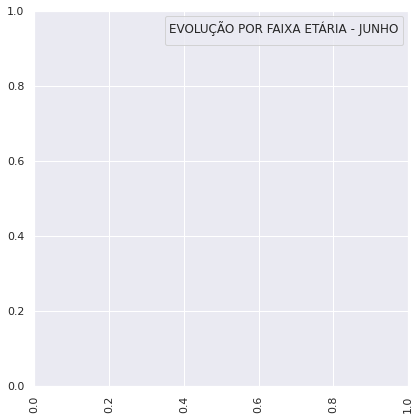

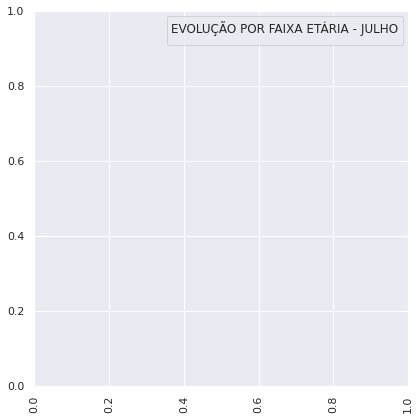

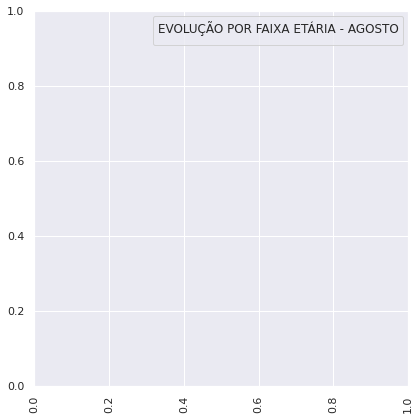

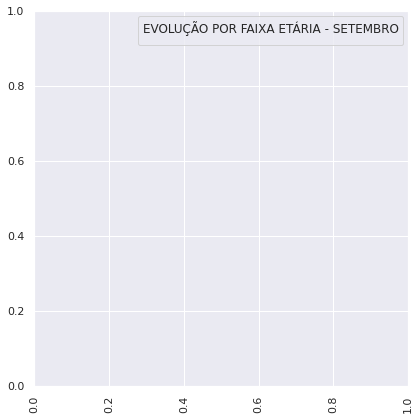

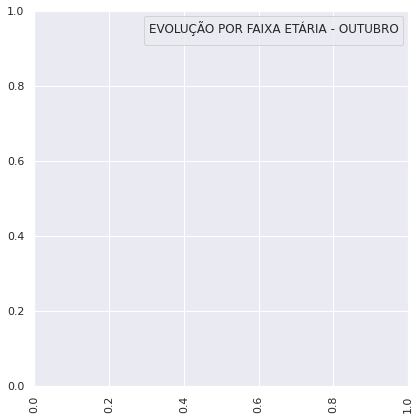

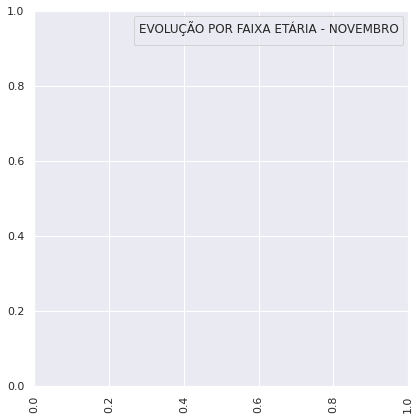

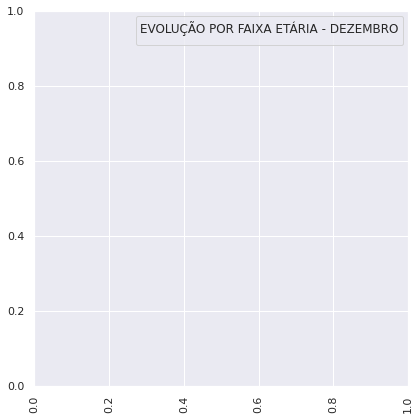

In [280]:
# set plot style: grey grid in the background:
sns.set(style="darkgrid")

unique = df_2021["EVOLUCAO"].append(df_2021["AGE_GROUP"]).unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
palette.update({"Total":"k"})

months = {1:'JANEIRO', 2:'FEVEREIRO', 3:'MARÇO', 4:'ABRIL', 5:'MAIO', 6:'JUNHO',
          7:'JULHO', 8:'AGOSTO', 9:'SETEMBRO', 10:'OUTUBRO', 11:'NOVEMBRO', 12:'DEZEMBRO'}

for month in months:

    # set the figure size
    plt.figure(figsize=(6, 6))
    
    evolutions_cat = {'1': 'CURA', '2': 'ÓBITO', '3': 'ÓBITO OUTRAS CAUSA', '9': 'IGNORADO', 'NULO': 'NULO'}

    data = df_2021[(df_2021['month(DT_SIN_PRI)'] == month) & (df_2021['EVOLUCAO'] == '1')]
    data.loc[:,['count']] = data['count']/10
    
    if len(data) > 0:
        bar1 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, ci=None, palette=palette)
        leg_bar1 = mpatches.Patch(color='darkblue', label='CURA')
        bar1.set(ylim=(0, 1500))

    data = df_2021[(df_2021['month(DT_SIN_PRI)'] == month) & (df_2021['EVOLUCAO'] == '2')]
    data.loc[:,['count']] = data['count']/10
    
    if len(data) > 0:
        bar2 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, estimator=sum, ci=None, palette=palette)
        leg_bar2 = mpatches.Patch(color='darkblue' ,label='ÓBITO')
        bar2.set(ylim=(0, 1500))

    data = df_2021[(df_2021['month(DT_SIN_PRI)'] == month) & (df_2021['EVOLUCAO'] == '3')]
    data.loc[:,['count']] = data['count']/10
    
    if len(data) > 0:
        bar3 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, estimator=sum, ci=None, palette=palette)
        leg_bar3 = mpatches.Patch(color='darkblue', label='ÓBITO OUTRAS CAUSAS')
        bar3.set(ylim=(0, 1500))

    data = df_2021[(df_2021['month(DT_SIN_PRI)'] == month) & (df_2021['EVOLUCAO'] == '9')]
    data.loc[:,['count']] = data['count']/10
    
    if len(data) > 0:
        bar4 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, estimator=sum, ci=None, palette=palette)
        leg_bar4 = mpatches.Patch(color='darkblue', label='IGNORADO')
        bar4.set(ylim=(0, 1500))

    data = df_2021[(df_2021['month(DT_SIN_PRI)'] == month) & (df_2021['EVOLUCAO'] == 'NULO')]
    data.loc[:,['count']] = data['count']/10
    
    if len(data) > 0:
        bar5 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, estimator=sum, ci=None, palette=palette)
        leg_bar5 = mpatches.Patch(color='darkblue', label='NULO')
        bar5.set(ylim=(0, 1500))

    plt.legend(title='EVOLUÇÃO POR FAIXA ETÁRIA - ' + months[month], loc='upper right', labels=['CURA / 10', 'OBITO / 10', 'OBITO OUTRAS CAUSAS / 10', 'NULO / 10'])
    plt.xticks(rotation='vertical')
    plt.tight_layout()

In [281]:
palette

{'NULO': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 '1': (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 '2': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 '3': (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 '9': (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 '< 1': (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 '1a5': (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 '6a19': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 '20a29': (0.8, 0.7254901960784313, 0.4549019607843137),
 '30a39': (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 '40 a 49': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 '50 a 59': (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 '60 a 69': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 '70 a 79': (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 '80 a 89': (0.505

<hr /> 

In [109]:
norte_v = ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
nordeste_v = ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']
centro_oeste_v = ['MT', 'MS', 'GO']
sudeste_v = ['SP', 'RJ', 'ES', 'MG']
sul_v = ['PR', 'RS', 'SC']

In [110]:
df_2019_norte = super_srag.filter((F.year('DT_SIN_PRI') == 2019) & (super_srag.SG_UF_NOT.isin(norte_v))).select(['DT_SIN_PRI', 'EVOLUCAO', 'AGE_GROUP'])\
            .groupBy([F.month('DT_SIN_PRI'), 'EVOLUCAO', 'AGE_GROUP']).count().orderBy(['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP']).toPandas()
df_2019_norte = df_2019_norte.fillna('NULO')

df_2019_nordeste = super_srag.filter((F.year('DT_SIN_PRI') == 2019) & (super_srag.SG_UF_NOT.isin(nordeste_v))).select(['DT_SIN_PRI', 'EVOLUCAO', 'AGE_GROUP'])\
            .groupBy([F.month('DT_SIN_PRI'), 'EVOLUCAO', 'AGE_GROUP']).count().orderBy(['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP']).toPandas()
df_2019_nordeste = df_2019_nordeste.fillna('NULO')

df_2019_centro = super_srag.filter((F.year('DT_SIN_PRI') == 2019) & (super_srag.SG_UF_NOT.isin(centro_oeste_v))).select(['DT_SIN_PRI', 'EVOLUCAO', 'AGE_GROUP'])\
            .groupBy([F.month('DT_SIN_PRI'), 'EVOLUCAO', 'AGE_GROUP']).count().orderBy(['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP']).toPandas()
df_2019_centro = df_2019_centro.fillna('NULO')

df_2019_sudeste = super_srag.filter((F.year('DT_SIN_PRI') == 2019) & (super_srag.SG_UF_NOT.isin(sudeste_v))).select(['DT_SIN_PRI', 'EVOLUCAO', 'AGE_GROUP'])\
            .groupBy([F.month('DT_SIN_PRI'), 'EVOLUCAO', 'AGE_GROUP']).count().orderBy(['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP']).toPandas()
df_2019_sudeste = df_2019_sudeste.fillna('NULO')

df_2019_sul = super_srag.filter((F.year('DT_SIN_PRI') == 2019) & (super_srag.SG_UF_NOT.isin(sul_v))).select(['DT_SIN_PRI', 'EVOLUCAO', 'AGE_GROUP'])\
            .groupBy([F.month('DT_SIN_PRI'), 'EVOLUCAO', 'AGE_GROUP']).count().orderBy(['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP']).toPandas()
df_2019_sul = df_2019_sul.fillna('NULO')

In [111]:
df_2020_norte = super_srag.filter((F.year('DT_SIN_PRI') == 2020) & (super_srag.SG_UF_NOT.isin(norte_v))).select(['DT_SIN_PRI', 'EVOLUCAO', 'AGE_GROUP'])\
            .groupBy([F.month('DT_SIN_PRI'), 'EVOLUCAO', 'AGE_GROUP']).count().orderBy(['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP']).toPandas()
df_2020_norte = df_2020_norte.fillna('NULO')

df_2020_nordeste = super_srag.filter((F.year('DT_SIN_PRI') == 2020) & (super_srag.SG_UF_NOT.isin(nordeste_v))).select(['DT_SIN_PRI', 'EVOLUCAO', 'AGE_GROUP'])\
            .groupBy([F.month('DT_SIN_PRI'), 'EVOLUCAO', 'AGE_GROUP']).count().orderBy(['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP']).toPandas()
df_2020_nordeste = df_2020_nordeste.fillna('NULO')

df_2020_centro = super_srag.filter((F.year('DT_SIN_PRI') == 2020) & (super_srag.SG_UF_NOT.isin(centro_oeste_v))).select(['DT_SIN_PRI', 'EVOLUCAO', 'AGE_GROUP'])\
            .groupBy([F.month('DT_SIN_PRI'), 'EVOLUCAO', 'AGE_GROUP']).count().orderBy(['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP']).toPandas()
df_2020_centro = df_2020_centro.fillna('NULO')

df_2020_sudeste = super_srag.filter((F.year('DT_SIN_PRI') == 2020) & (super_srag.SG_UF_NOT.isin(sudeste_v))).select(['DT_SIN_PRI', 'EVOLUCAO', 'AGE_GROUP'])\
            .groupBy([F.month('DT_SIN_PRI'), 'EVOLUCAO', 'AGE_GROUP']).count().orderBy(['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP']).toPandas()
df_2020_sudeste = df_2020_sudeste.fillna('NULO')

df_2020_sul = super_srag.filter((F.year('DT_SIN_PRI') == 2020) & (super_srag.SG_UF_NOT.isin(sul_v))).select(['DT_SIN_PRI', 'EVOLUCAO', 'AGE_GROUP'])\
            .groupBy([F.month('DT_SIN_PRI'), 'EVOLUCAO', 'AGE_GROUP']).count().orderBy(['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP']).toPandas()
df_2020_sul = df_2020_sul.fillna('NULO')

In [112]:
df_2021_norte = super_srag.filter((F.year('DT_SIN_PRI') == 2021) & (super_srag.SG_UF_NOT.isin(norte_v))).select(['DT_SIN_PRI', 'EVOLUCAO', 'AGE_GROUP'])\
            .groupBy([F.month('DT_SIN_PRI'), 'EVOLUCAO', 'AGE_GROUP']).count().orderBy(['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP']).toPandas()
df_2021_norte = df_2021_norte.fillna('NULO')

df_2021_nordeste = super_srag.filter((F.year('DT_SIN_PRI') == 2021) & (super_srag.SG_UF_NOT.isin(nordeste_v))).select(['DT_SIN_PRI', 'EVOLUCAO', 'AGE_GROUP'])\
            .groupBy([F.month('DT_SIN_PRI'), 'EVOLUCAO', 'AGE_GROUP']).count().orderBy(['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP']).toPandas()
df_2021_nordeste = df_2021_nordeste.fillna('NULO')

df_2021_centro = super_srag.filter((F.year('DT_SIN_PRI') == 2021) & (super_srag.SG_UF_NOT.isin(centro_oeste_v))).select(['DT_SIN_PRI', 'EVOLUCAO', 'AGE_GROUP'])\
            .groupBy([F.month('DT_SIN_PRI'), 'EVOLUCAO', 'AGE_GROUP']).count().orderBy(['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP']).toPandas()
df_2021_centro = df_2021_centro.fillna('NULO')

df_2021_sudeste = super_srag.filter((F.year('DT_SIN_PRI') == 2021) & (super_srag.SG_UF_NOT.isin(sudeste_v))).select(['DT_SIN_PRI', 'EVOLUCAO', 'AGE_GROUP'])\
            .groupBy([F.month('DT_SIN_PRI'), 'EVOLUCAO', 'AGE_GROUP']).count().orderBy(['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP']).toPandas()
df_2021_sudeste = df_2021_sudeste.fillna('NULO')

df_2021_sul = super_srag.filter((F.year('DT_SIN_PRI') == 2021) & (super_srag.SG_UF_NOT.isin(sul_v))).select(['DT_SIN_PRI', 'EVOLUCAO', 'AGE_GROUP'])\
            .groupBy([F.month('DT_SIN_PRI'), 'EVOLUCAO', 'AGE_GROUP']).count().orderBy(['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP']).toPandas()
df_2021_sul = df_2021_sul.fillna('NULO')

In [113]:
age_groups = {1: '< 1', 2:'1 a 5', 3:'6 a 19', 4:'20 a 29', 5:'30 a 39', 6:'40 a 49', 7:'50 a 59', 8:'60 a 69', 9:'70 a 79', 10:'80 a 89', 11:'90+', 12:'NULO'}

for ag in list(age_groups.keys()):
    df_2019_norte['AGE_GROUP'] = df_2019_norte['AGE_GROUP'].replace(ag, age_groups[ag])
    df_2019_nordeste['AGE_GROUP'] = df_2019_nordeste['AGE_GROUP'].replace(ag, age_groups[ag])
    df_2019_centro['AGE_GROUP'] = df_2019_centro['AGE_GROUP'].replace(ag, age_groups[ag])
    df_2019_sudeste['AGE_GROUP'] = df_2019_sudeste['AGE_GROUP'].replace(ag, age_groups[ag])
    df_2019_sul['AGE_GROUP'] = df_2019_sul['AGE_GROUP'].replace(ag, age_groups[ag])
    
    df_2020_norte['AGE_GROUP'] = df_2020_norte['AGE_GROUP'].replace(ag, age_groups[ag])
    df_2020_nordeste['AGE_GROUP'] = df_2020_nordeste['AGE_GROUP'].replace(ag, age_groups[ag])
    df_2020_centro['AGE_GROUP'] = df_2020_centro['AGE_GROUP'].replace(ag, age_groups[ag])
    df_2020_sudeste['AGE_GROUP'] = df_2020_sudeste['AGE_GROUP'].replace(ag, age_groups[ag])
    df_2020_sul['AGE_GROUP'] = df_2020_sul['AGE_GROUP'].replace(ag, age_groups[ag])
    
    df_2021_norte['AGE_GROUP'] = df_2021_norte['AGE_GROUP'].replace(ag, age_groups[ag])
    df_2021_nordeste['AGE_GROUP'] = df_2021_nordeste['AGE_GROUP'].replace(ag, age_groups[ag])
    df_2021_centro['AGE_GROUP'] = df_2021_centro['AGE_GROUP'].replace(ag, age_groups[ag])
    df_2021_sudeste['AGE_GROUP'] = df_2021_sudeste['AGE_GROUP'].replace(ag, age_groups[ag])
    df_2021_sul['AGE_GROUP'] = df_2021_sul['AGE_GROUP'].replace(ag, age_groups[ag])

In [114]:
# making a dictionary to support the plot automatization for every stacked bars in different region, month, and case evolution
dfs = {
    'df_2019_norte': ['NORTE' ,df_2019_norte], 
    'df_2019_nordeste': ['NORDESTE', df_2019_nordeste], 
    'df_2019_centro': ['CNT OESTE', df_2019_centro], 
    'df_2019_sudeste':['SUDESTE', df_2019_sudeste], 
    'df_2019_sul':['SUL', df_2019_sul],
    'df_2020_norte': ['NORTE' ,df_2020_norte], 
    'df_2020_nordeste': ['NORDESTE', df_2020_nordeste], 
    'df_2020_centro': ['CENTRO OESTE', df_2020_centro], 
    'df_2020_sudeste':['SUDESTE', df_2020_sudeste], 
    'df_2020_sul':['SUL', df_2020_sul],
    'df_2021_norte': ['NORTE' ,df_2021_norte], 
    'df_2021_nordeste': ['NORDESTE', df_2021_nordeste], 
    'df_2021_centro': ['CENTRO OESTE', df_2021_centro], 
    'df_2021_sudeste':['SUDESTE', df_2021_sudeste], 
    'df_2021_sul':['SUL', df_2021_sul]
      }

In [115]:
# setting empty dataframe to avoid plots without some bars
unique = df_2021["EVOLUCAO"].append(df_2021["AGE_GROUP"]).unique()
empty = df_2020[(df_2020['month(DT_SIN_PRI)'] == '1') & (df_2020['EVOLUCAO'] == '1')]
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
palette.update({"Total":"k"})

In [116]:
age_groups = {1: '< 1', 2:'1 a 5', 3:'6 a 19', 4:'20 a 29', 5:'30 a 39', 6:'40 a 49', 7:'50 a 59', 8:'60 a 69', 9:'70 a 79', 10:'80 a 89', 11:'90+', 12:'NULO'}

In [117]:
# adding missing age groups to fill the plot

def complete_df_ag(month, evolution, df):
    age_groups = {1: '< 1', 2:'1 a 5', 3:'6 a 19', 4:'20 a 29', 5:'30 a 39', 6:'40 a 49', 7:'50 a 59', 8:'60 a 69', 9:'70 a 79', 10:'80 a 89', 11:'90+', 12:'NULO'}
    for ag in list(age_groups.values()):
        if ag not in df['AGE_GROUP'].tolist():
            df_temp = pd.DataFrame([[month, evolution, ag, 0]], columns=['month(DT_SIN_PRI)', 'EVOLUCAO', 'AGE_GROUP', 'count'])
            df = df.append(df_temp)
    return df

/opt/conda/anaconda/bin/ipython:13: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/opt/conda/anaconda/bin/ipython:13: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/opt/conda/anaconda/bin/ipython:13: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/opt/conda/anaconda/bin/ipython:13: RuntimeWarning:

More than 20 figures have 

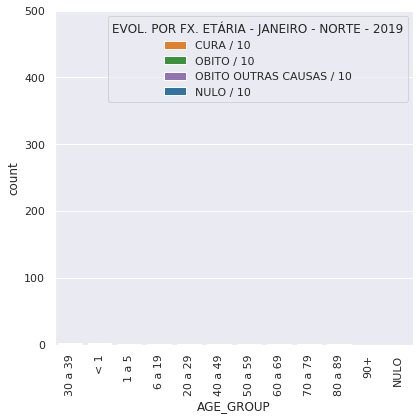

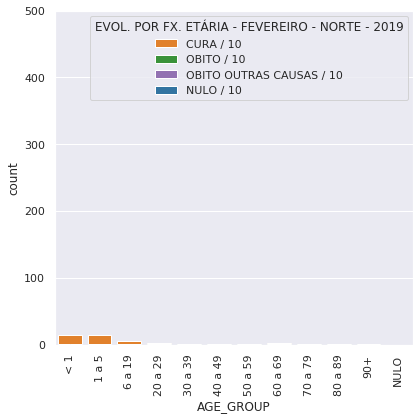

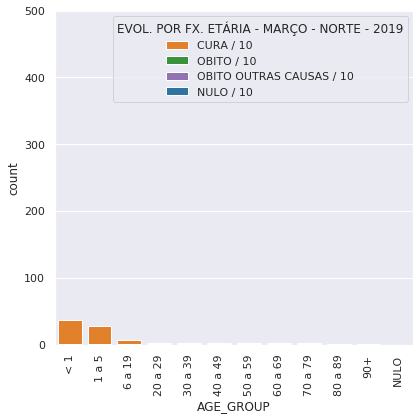

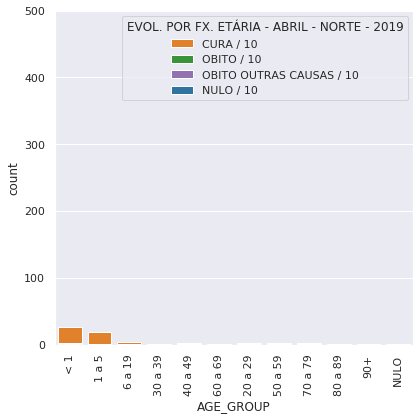

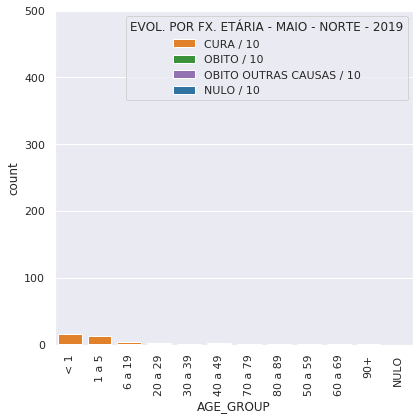

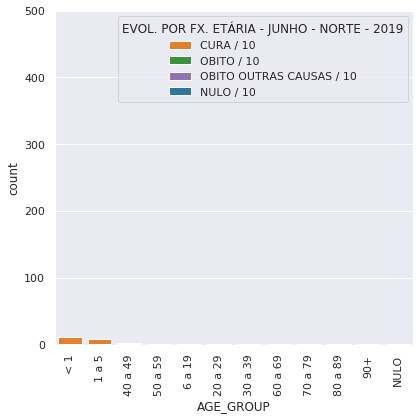

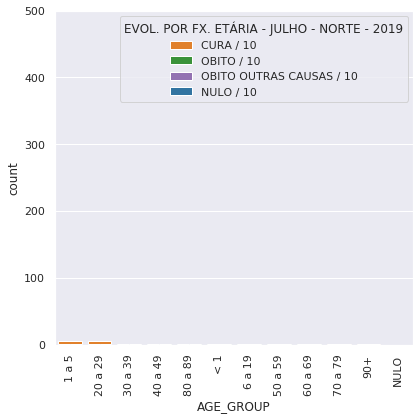

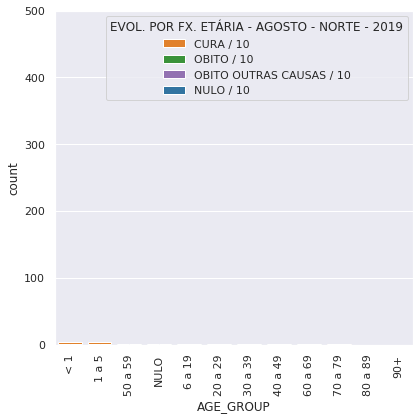

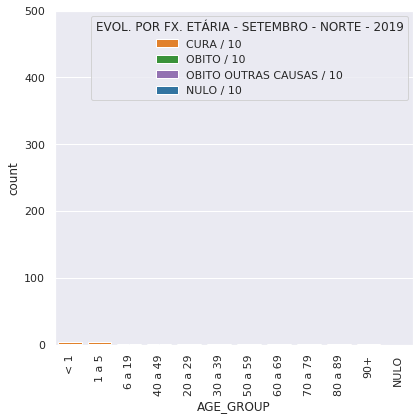

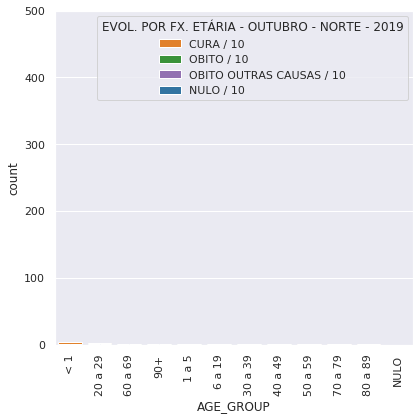

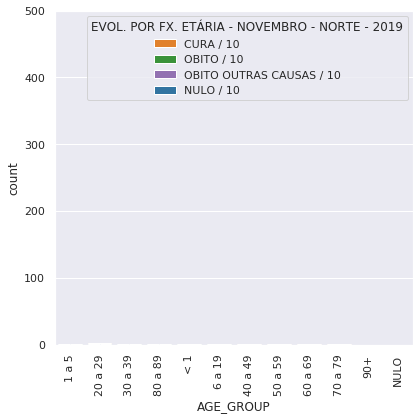

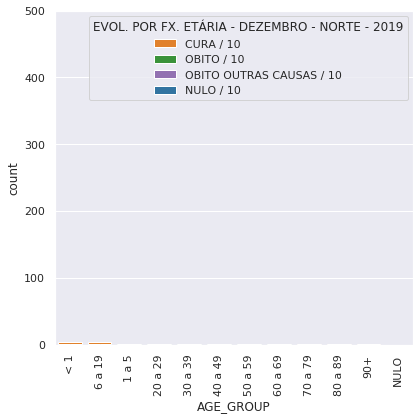

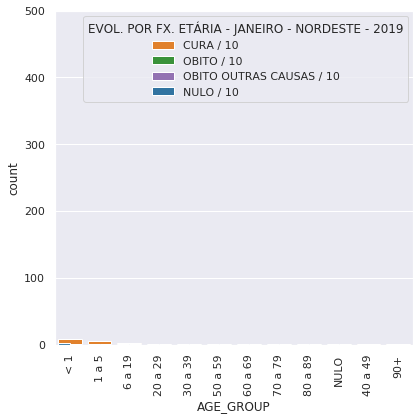

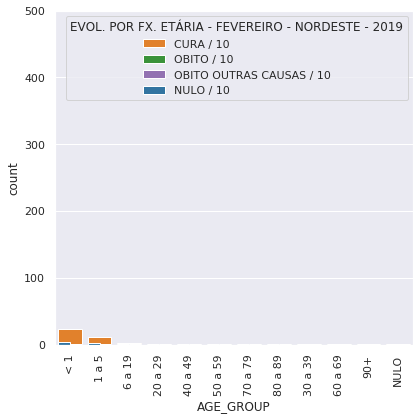

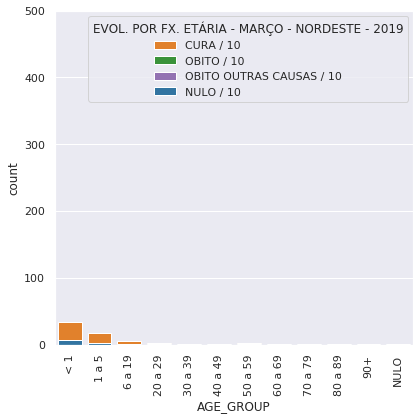

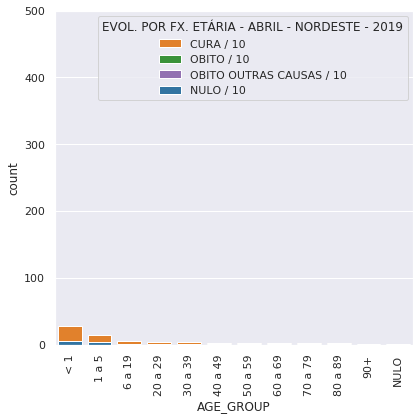

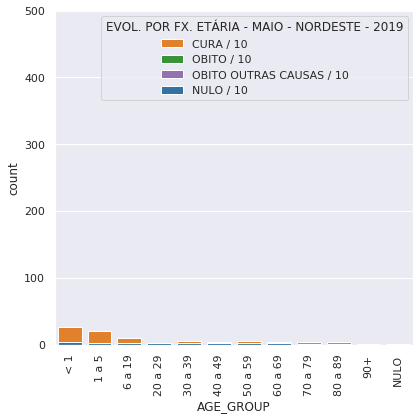

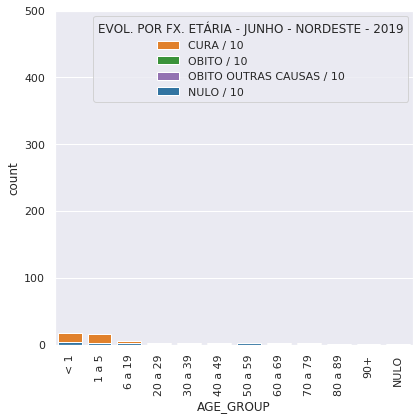

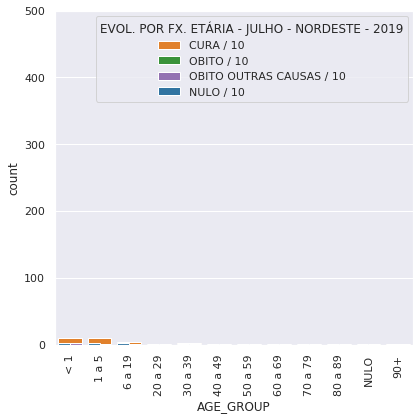

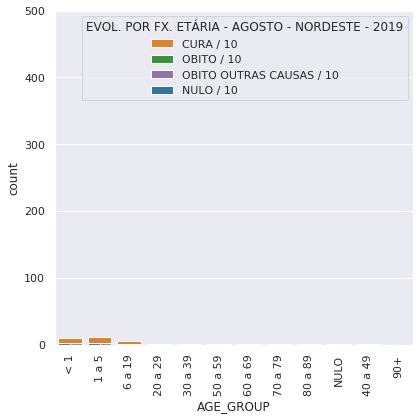

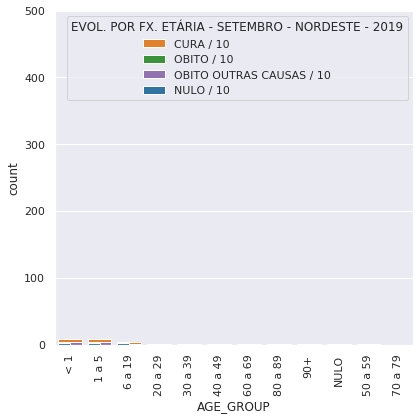

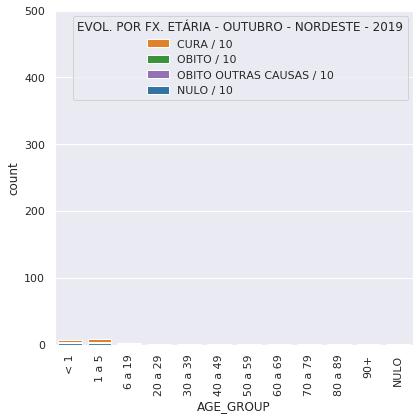

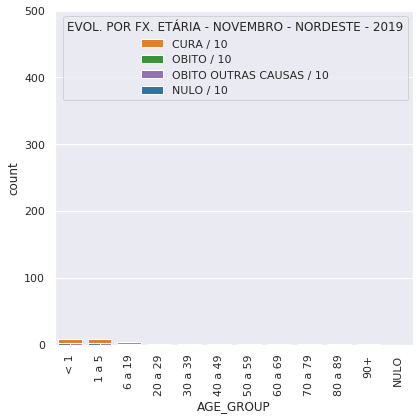

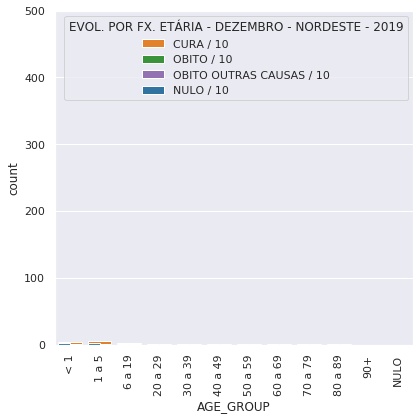

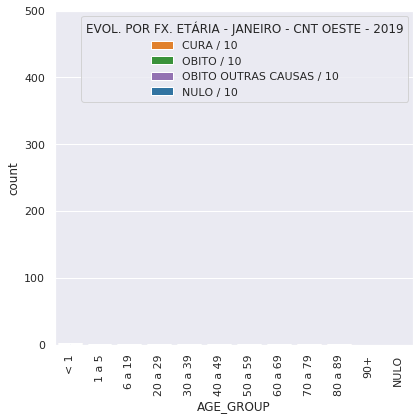

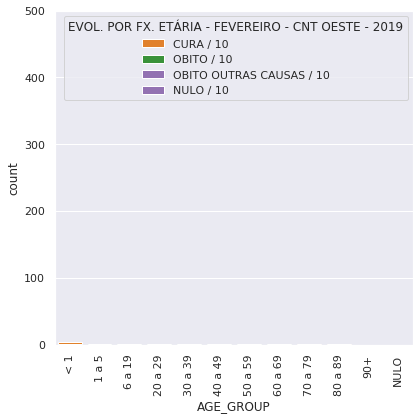

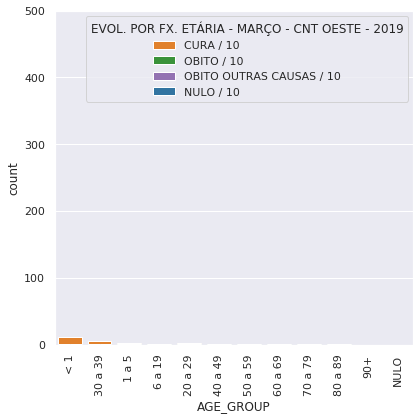

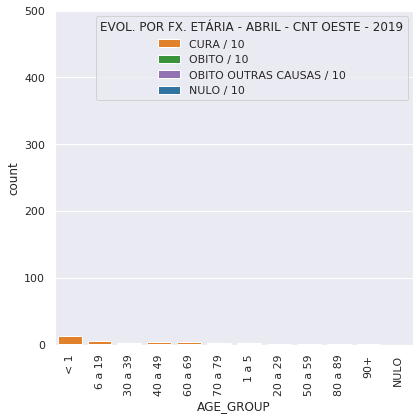

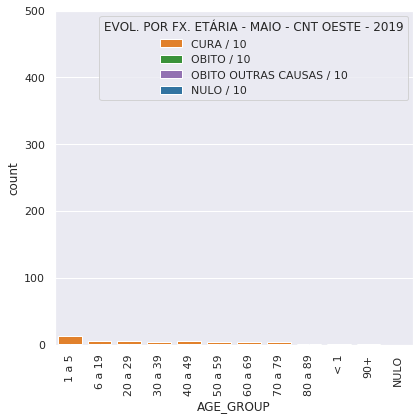

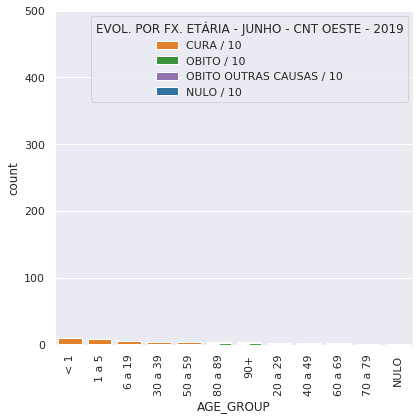

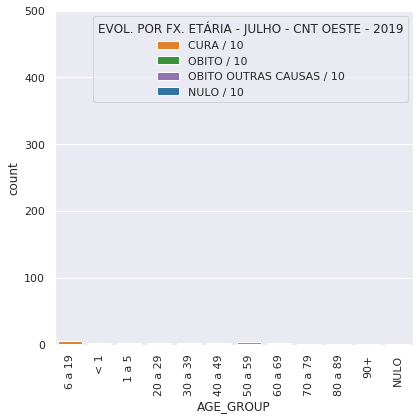

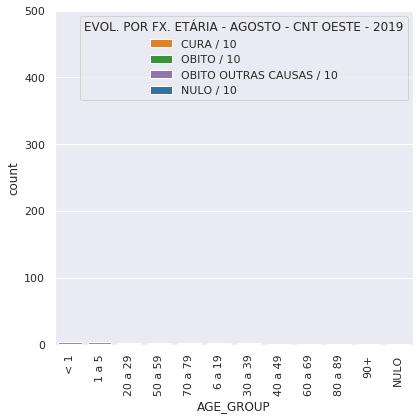

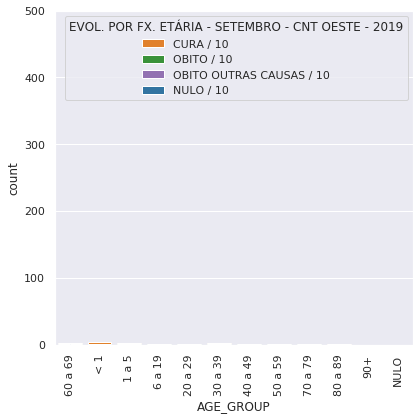

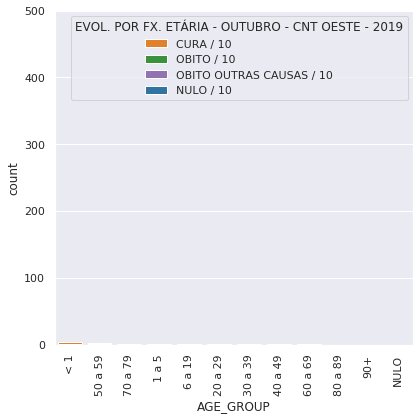

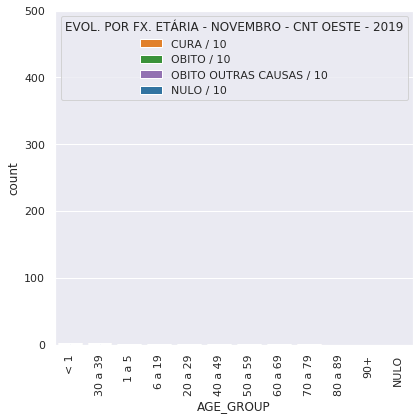

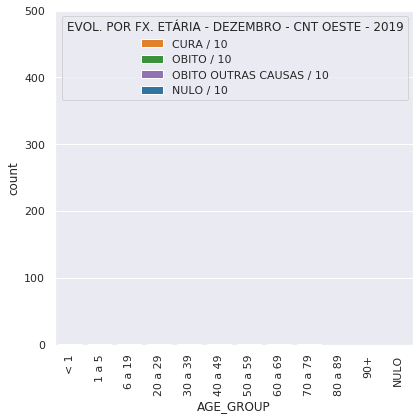

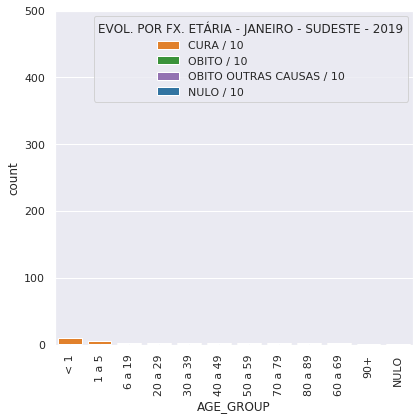

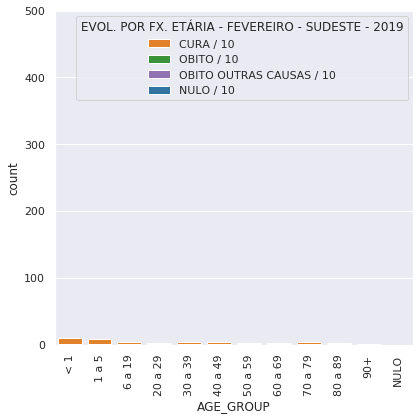

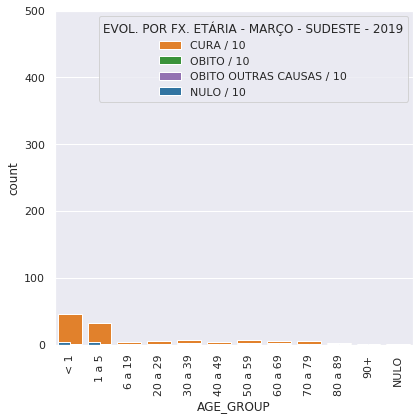

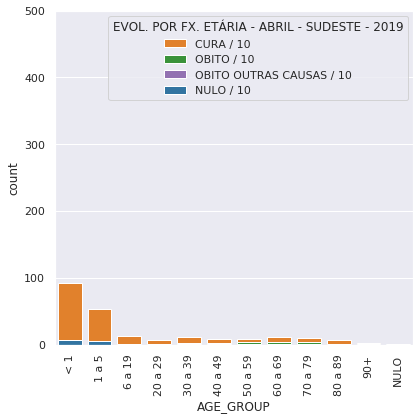

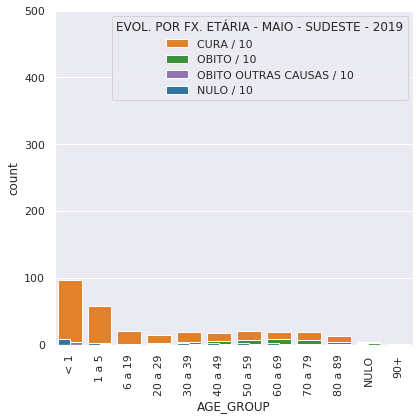

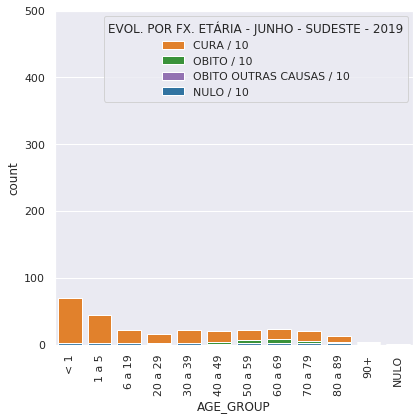

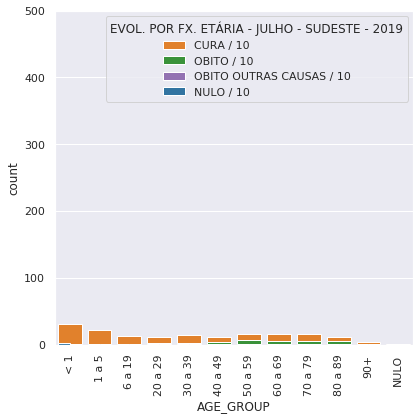

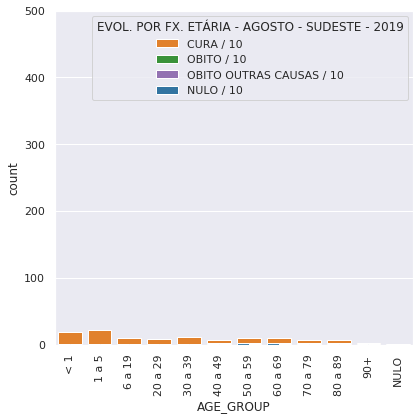

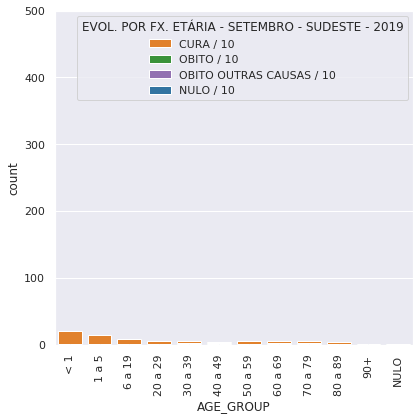

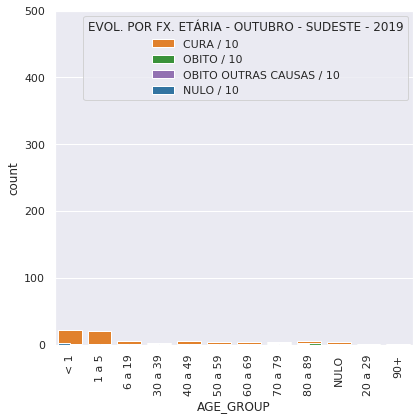

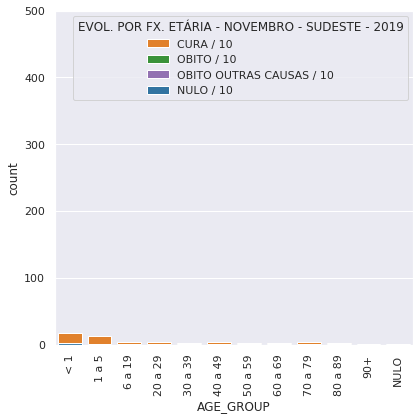

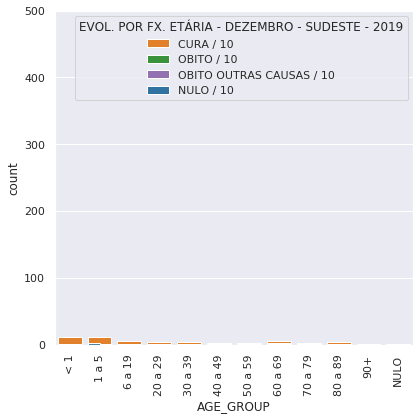

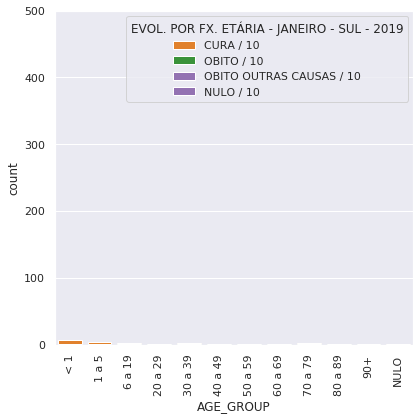

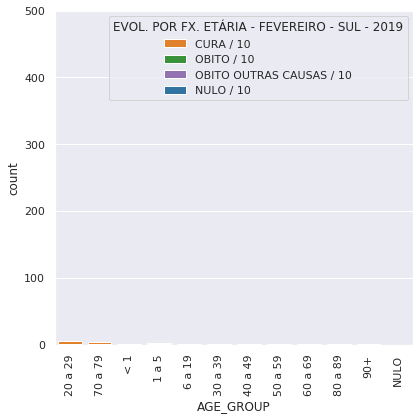

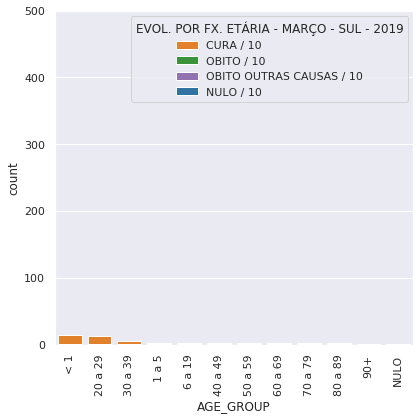

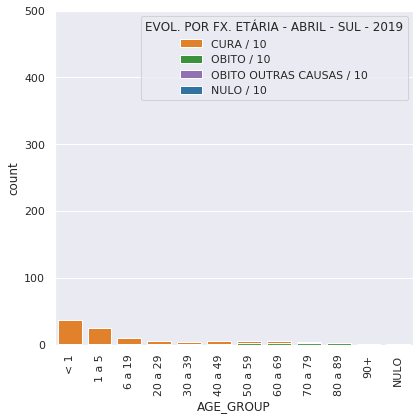

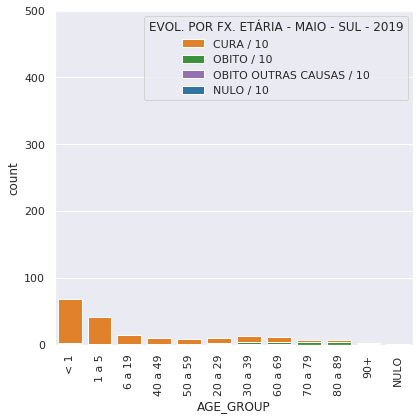

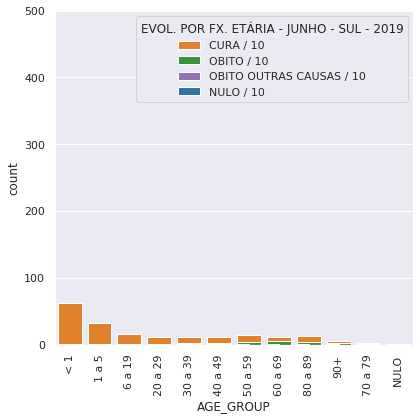

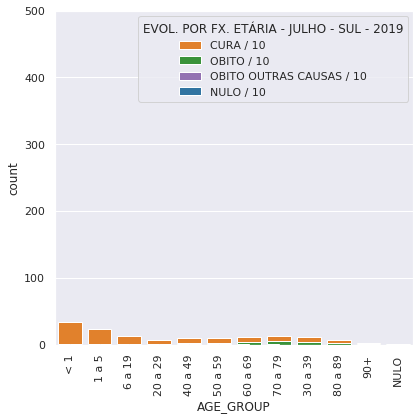

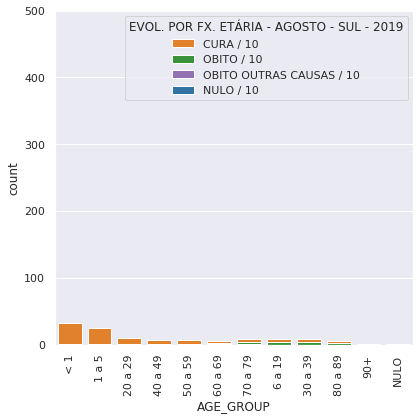

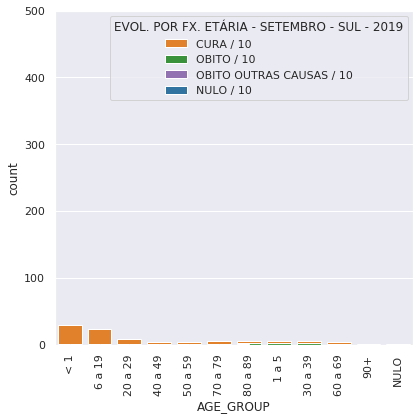

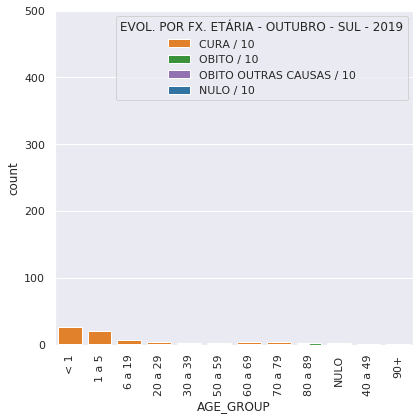

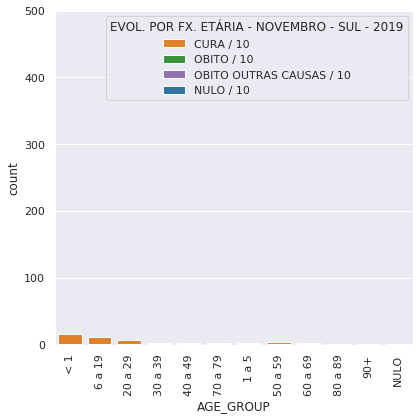

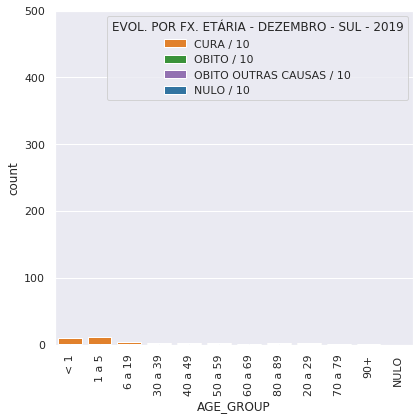

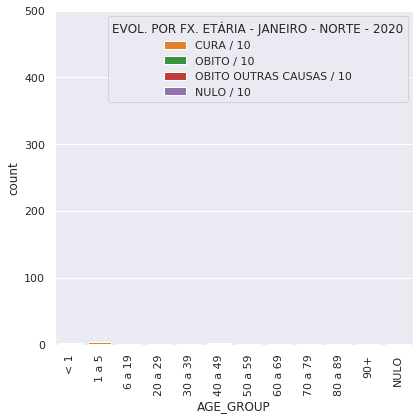

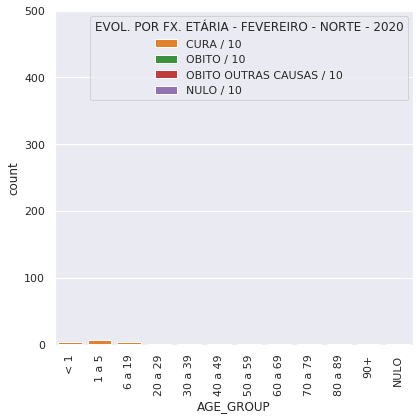

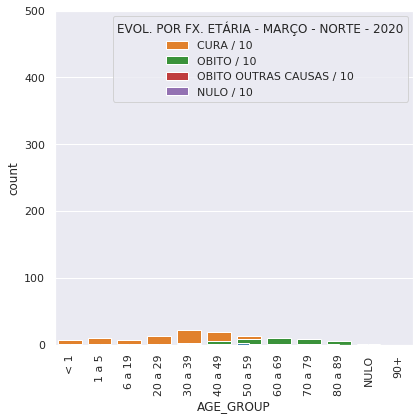

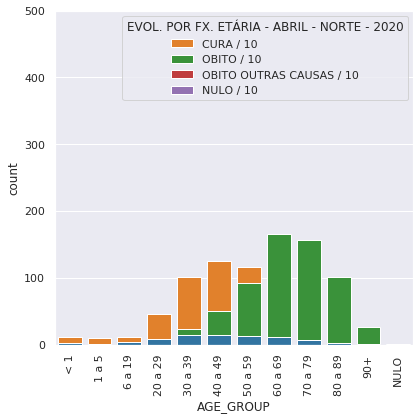

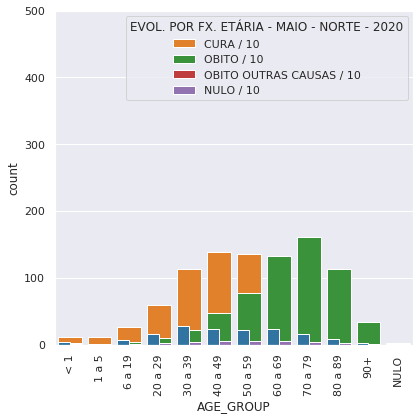

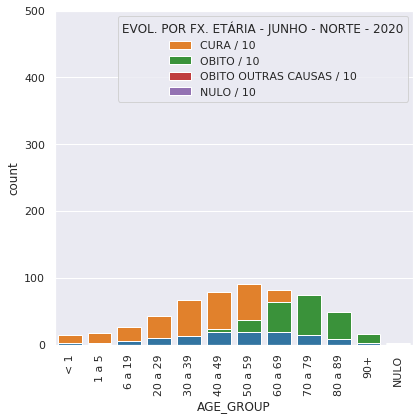

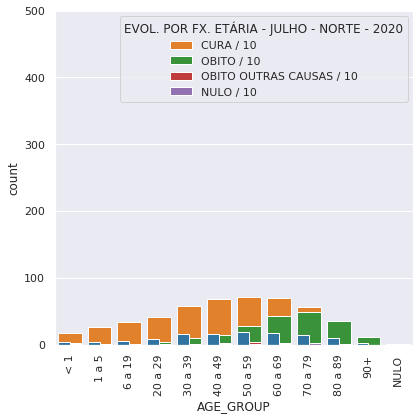

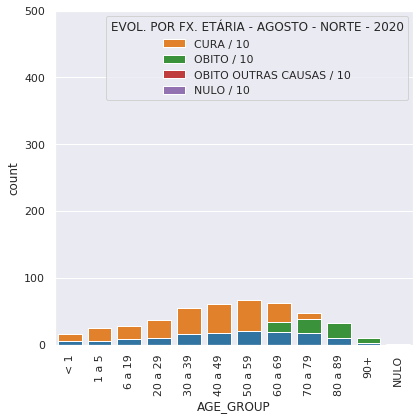

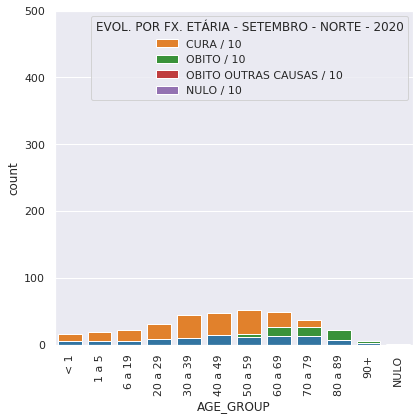

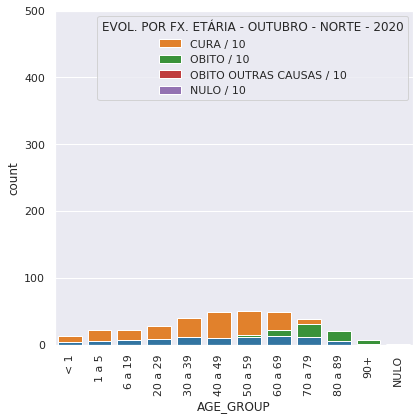

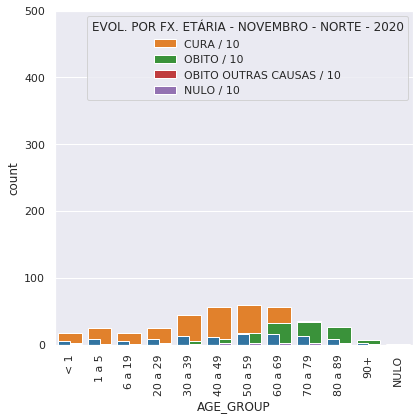

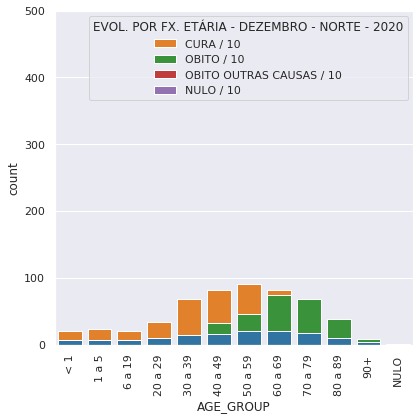

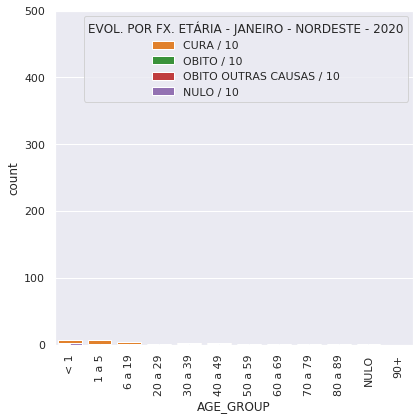

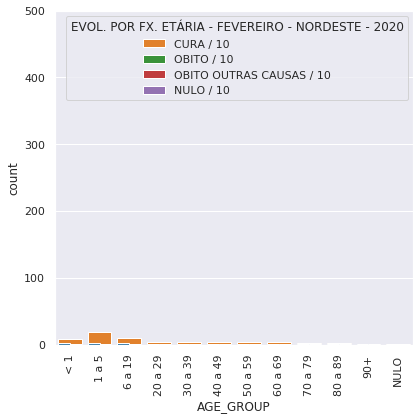

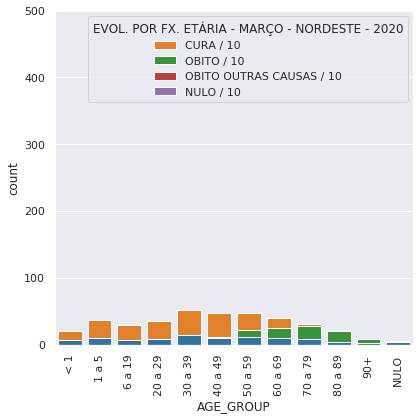

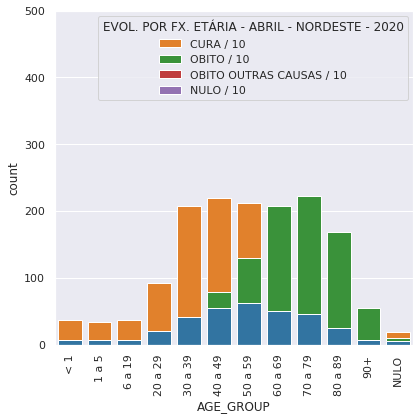

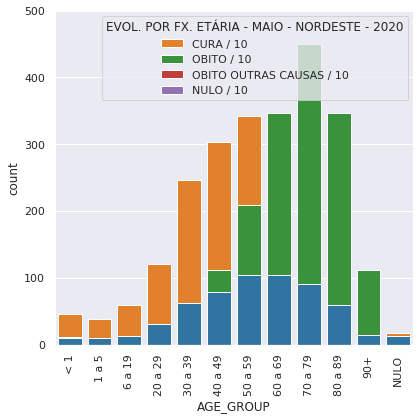

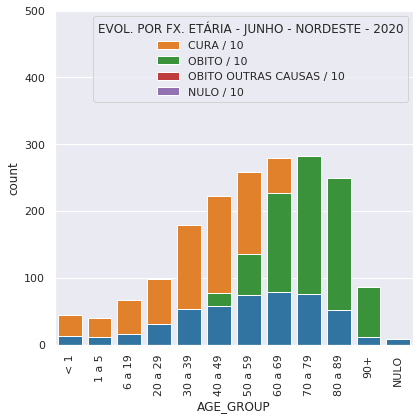

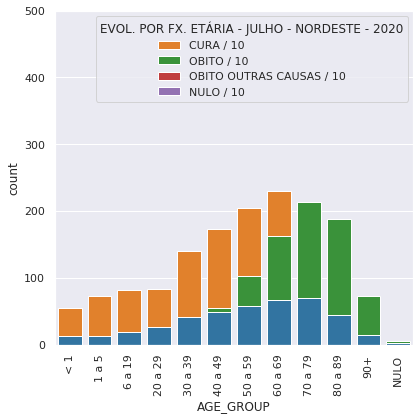

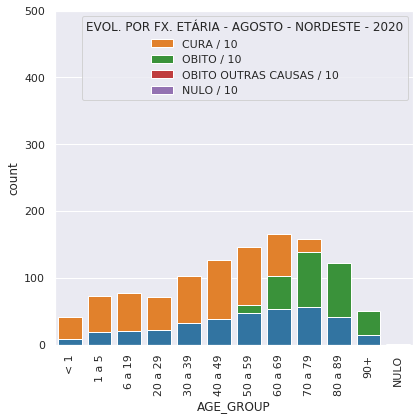

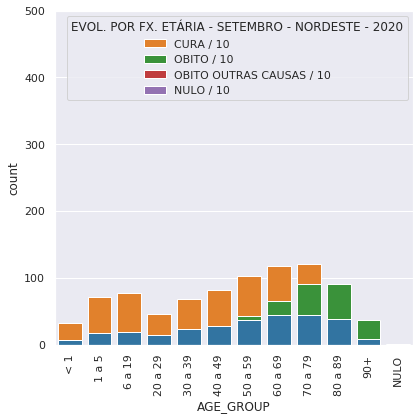

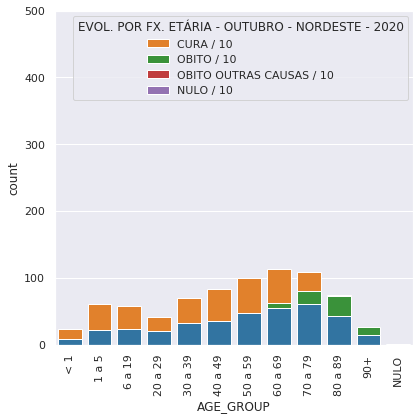

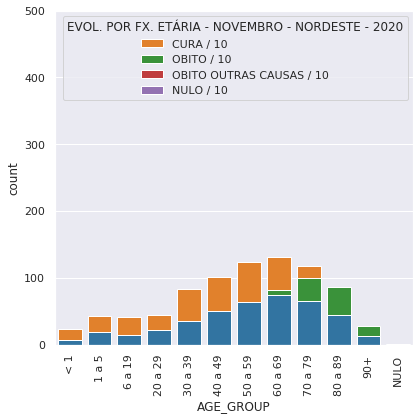

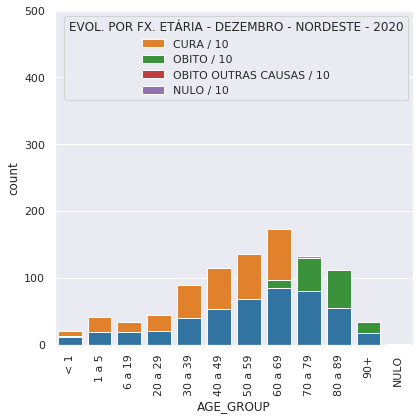

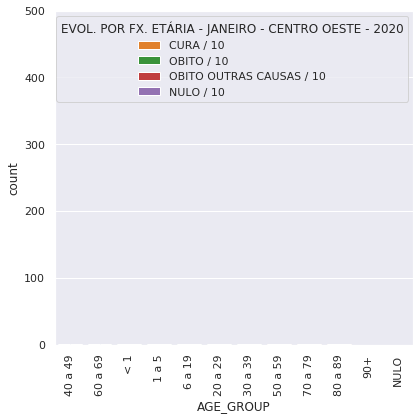

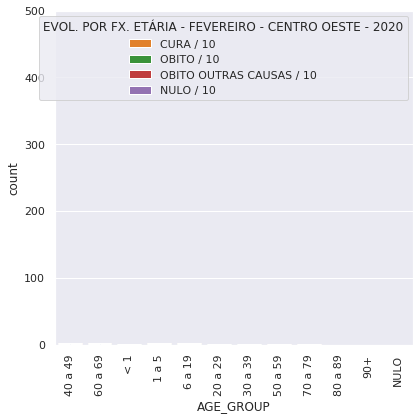

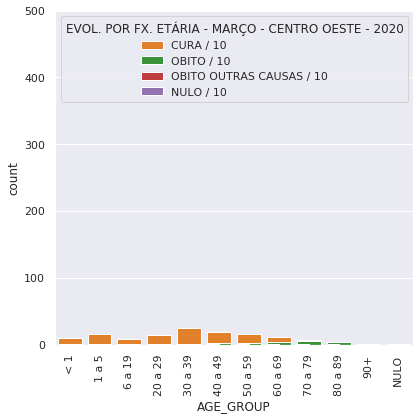

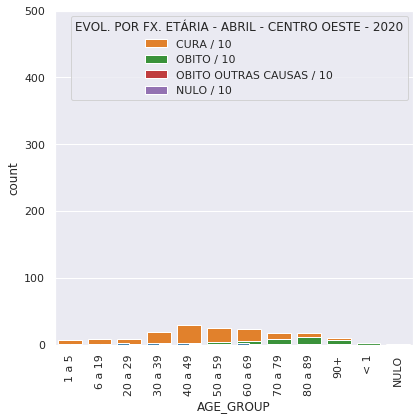

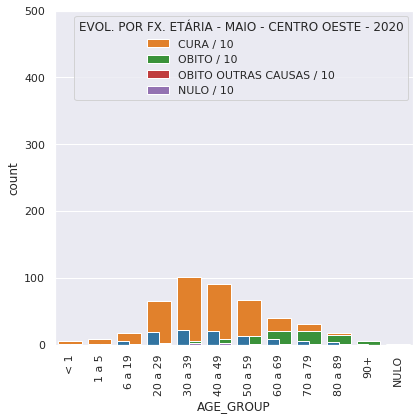

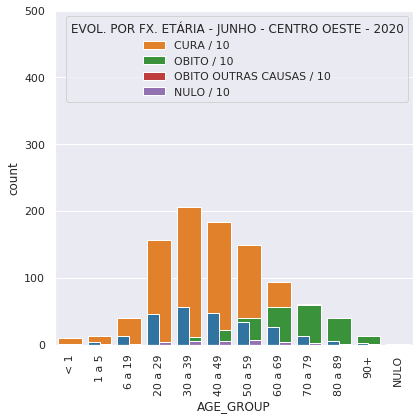

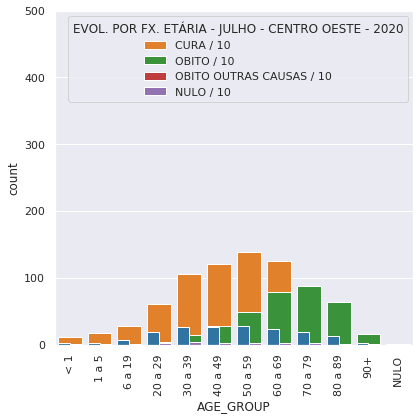

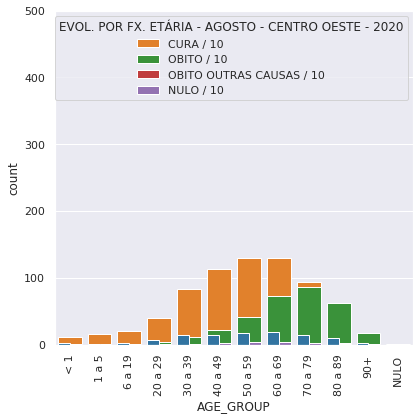

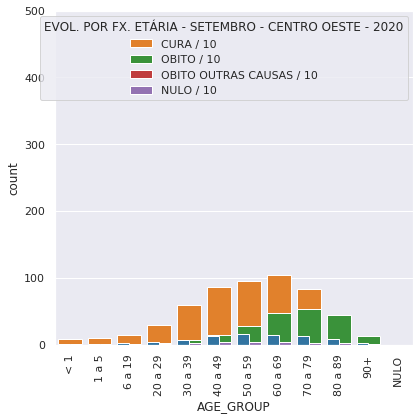

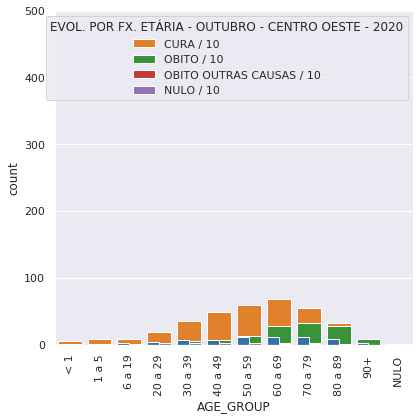

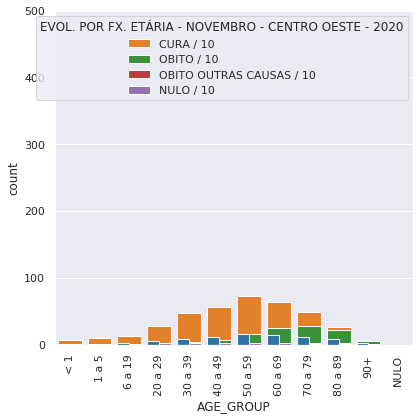

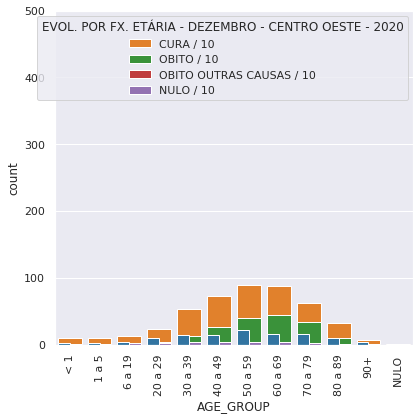

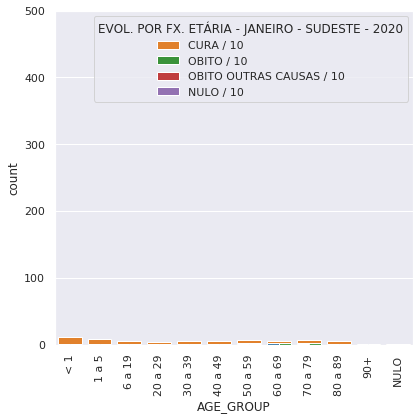

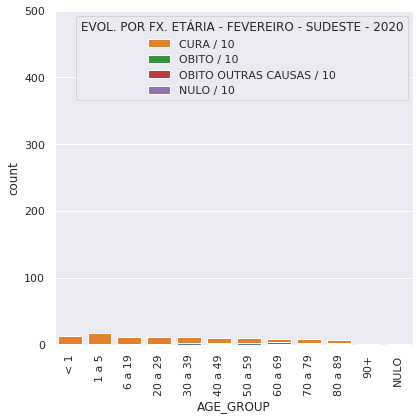

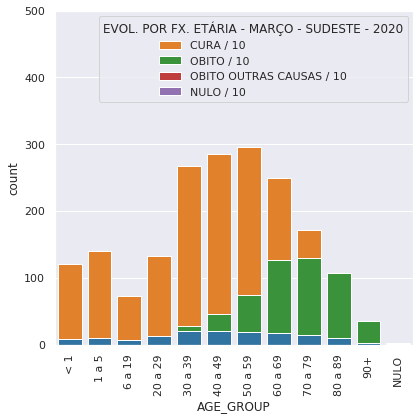

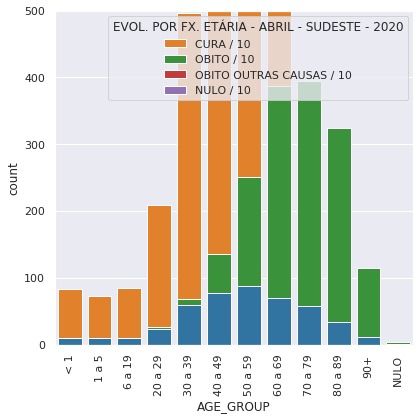

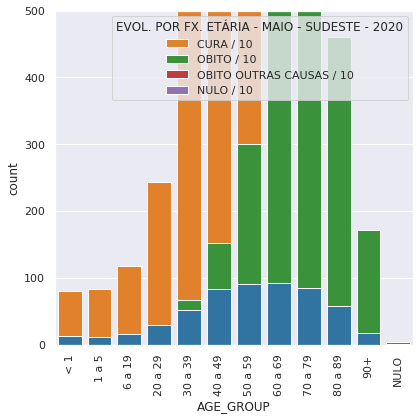

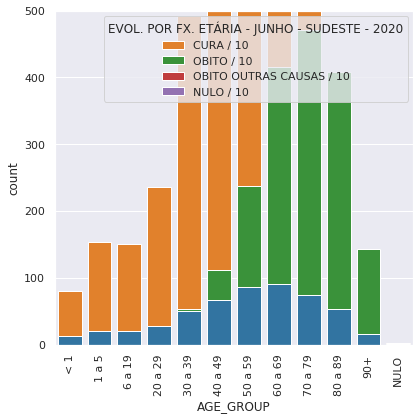

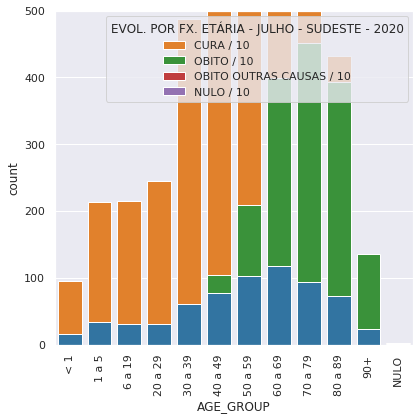

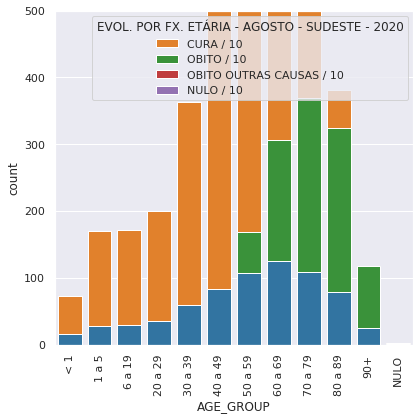

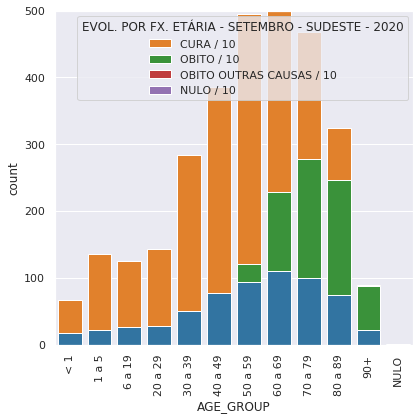

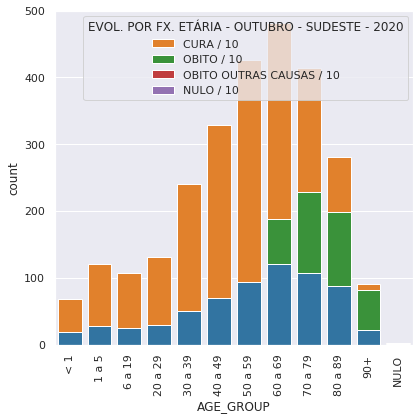

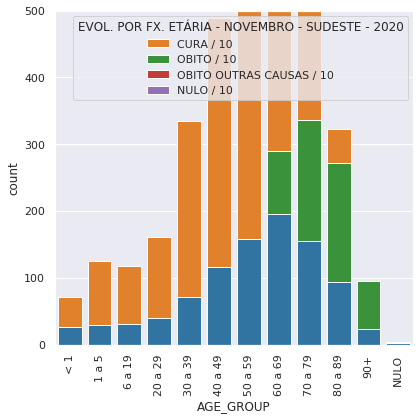

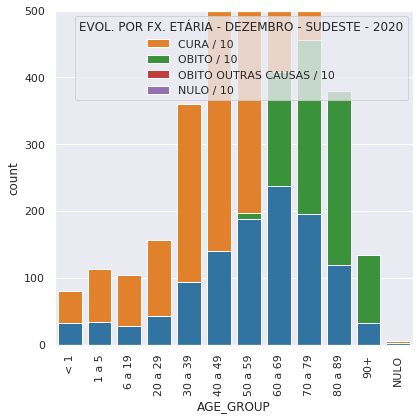

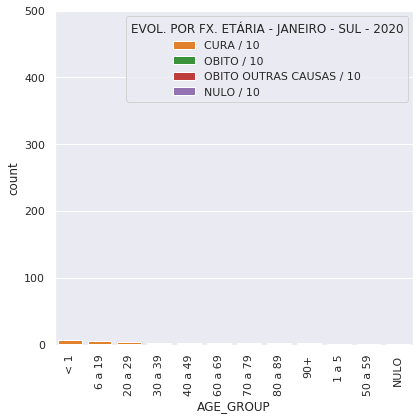

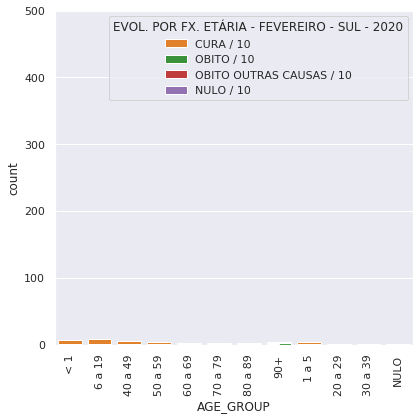

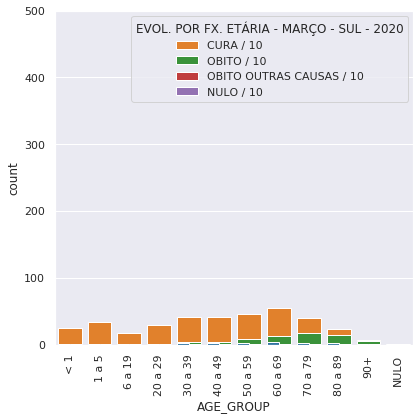

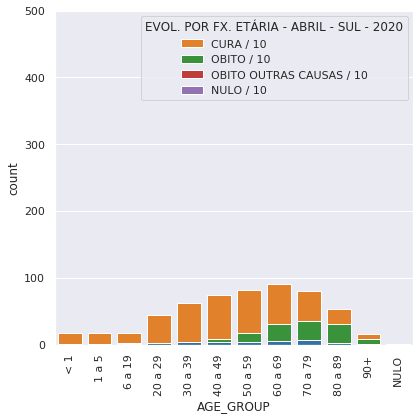

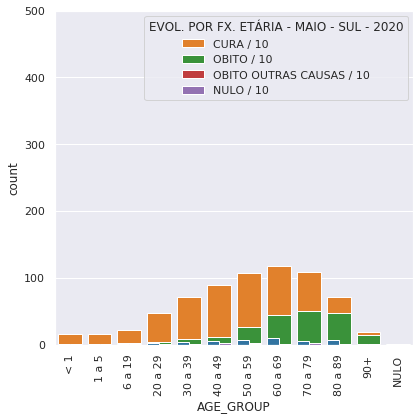

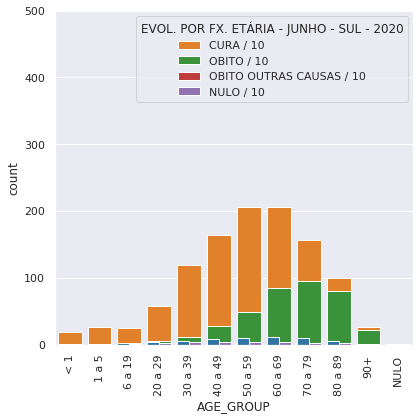

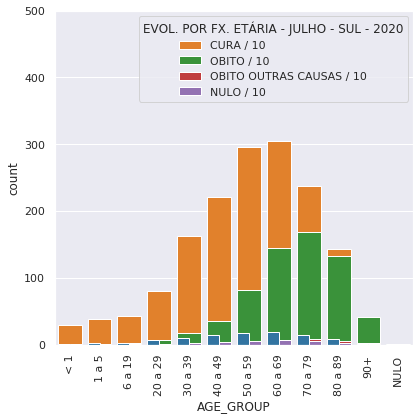

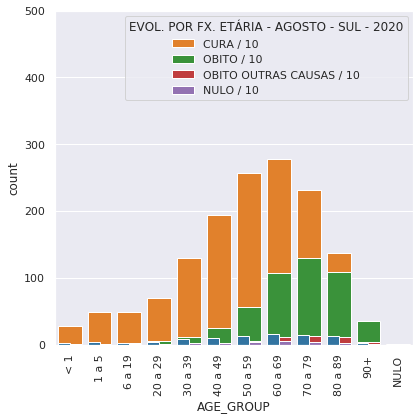

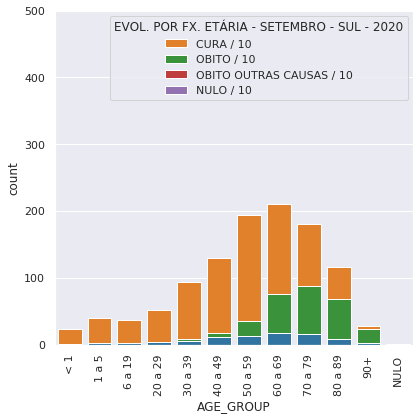

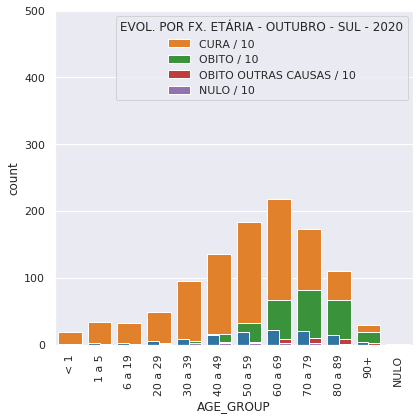

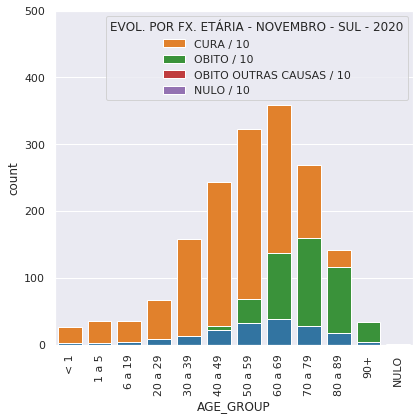

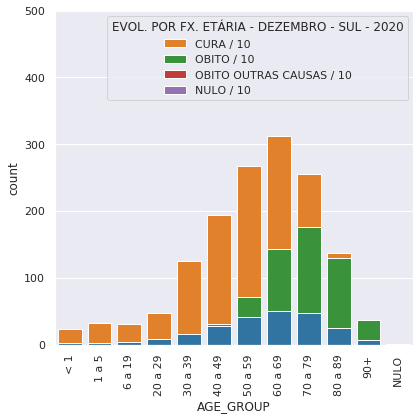

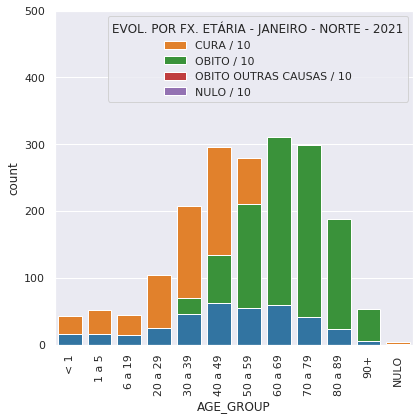

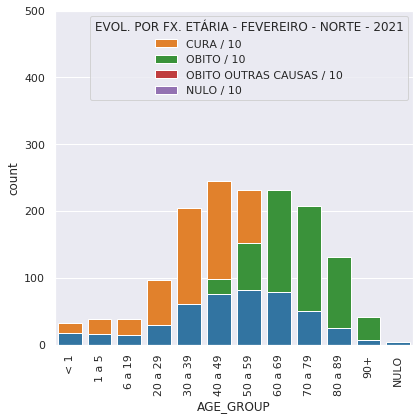

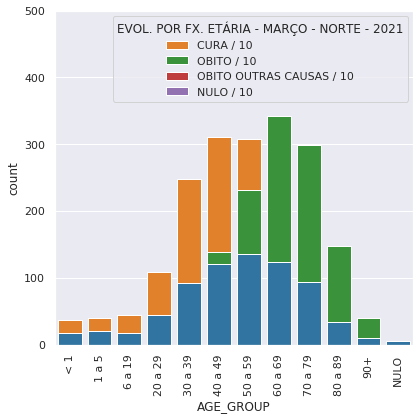

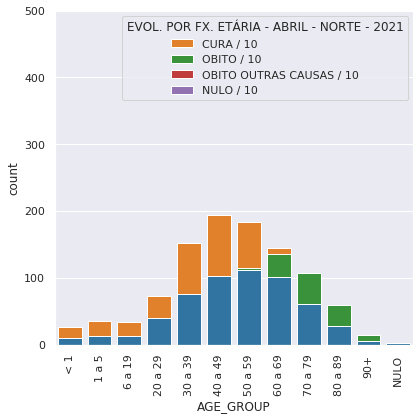

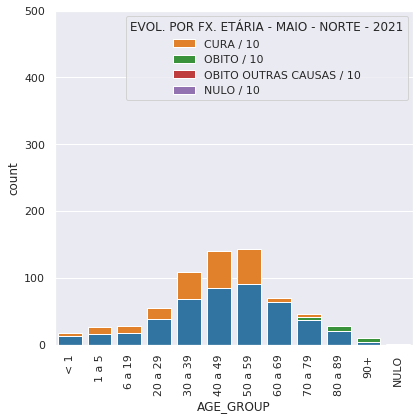

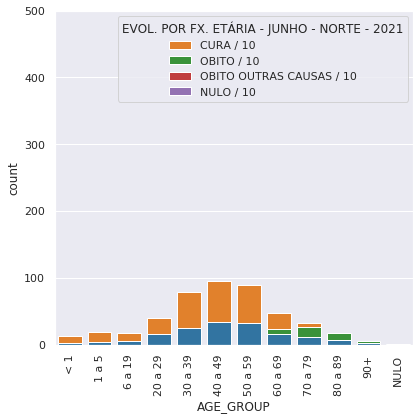

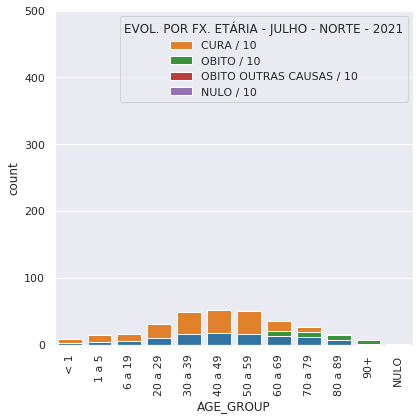

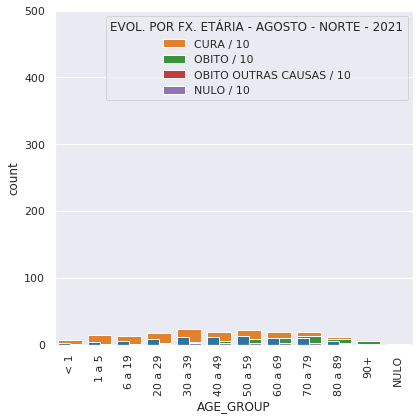

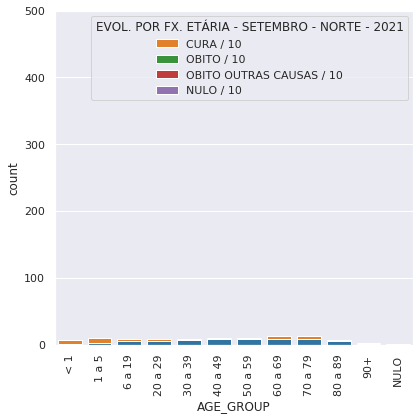

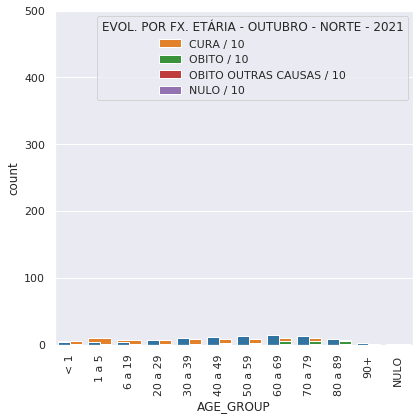

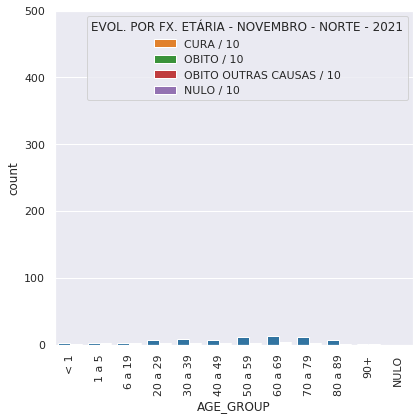

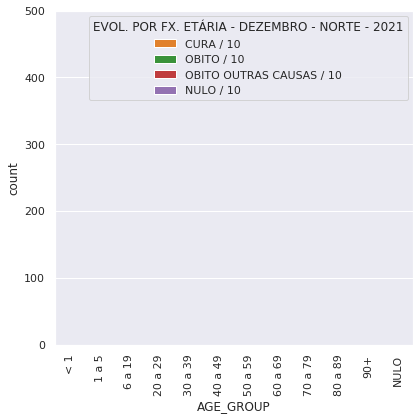

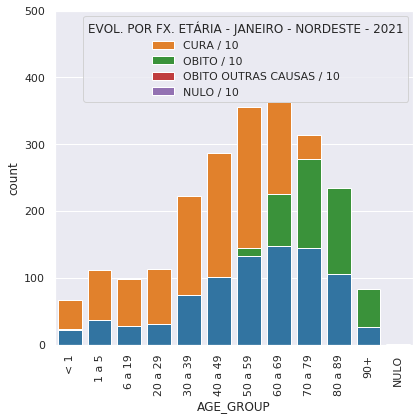

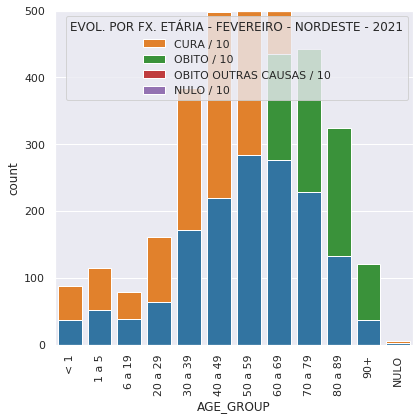

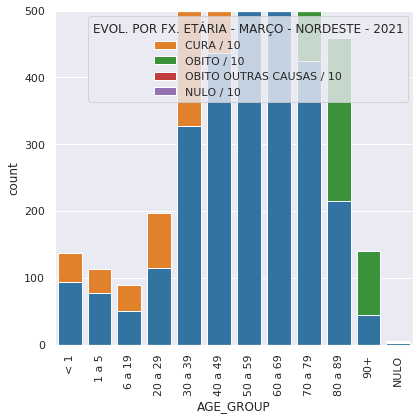

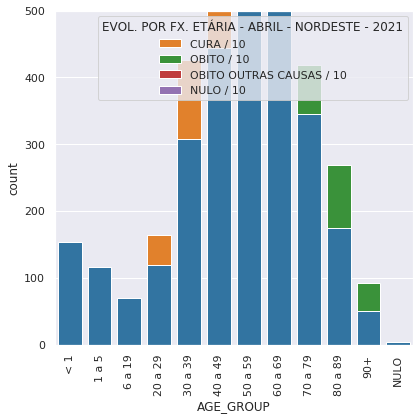

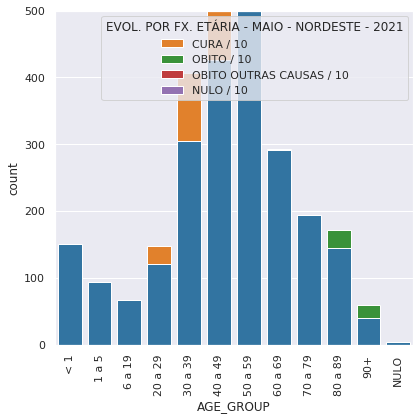

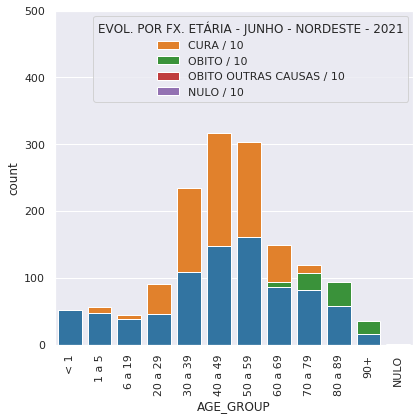

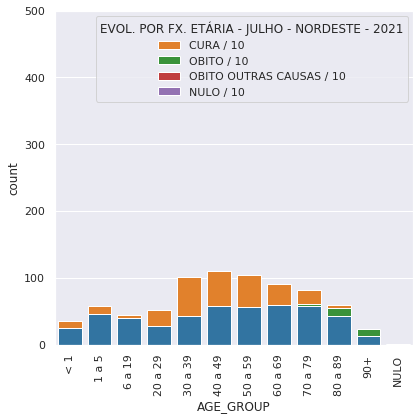

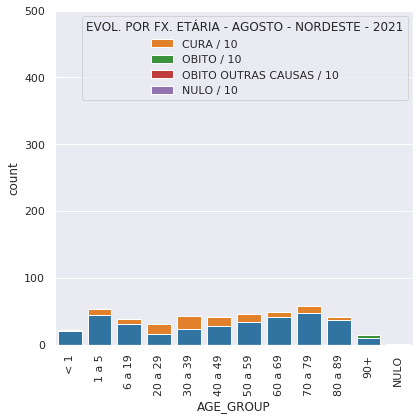

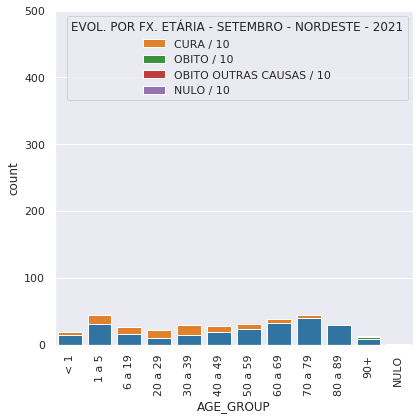

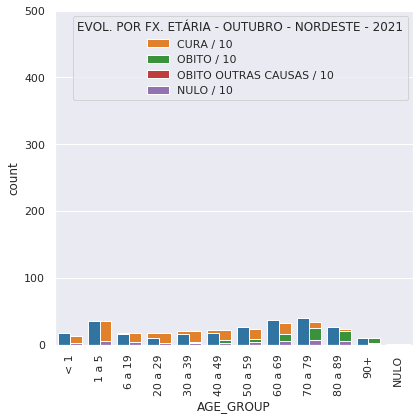

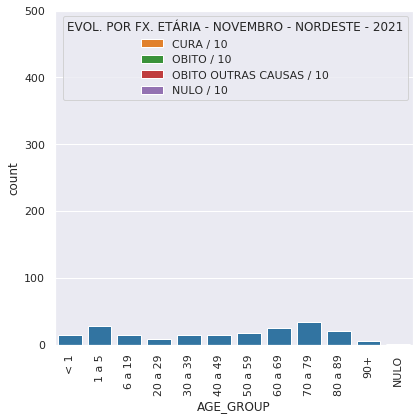

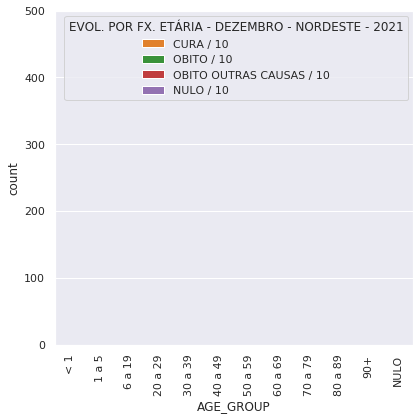

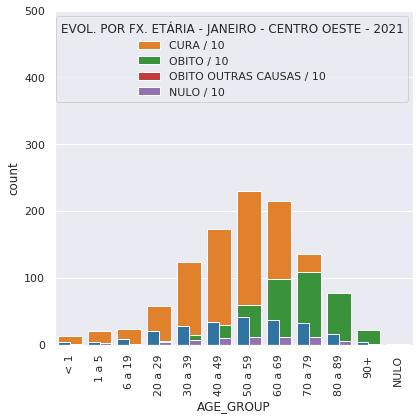

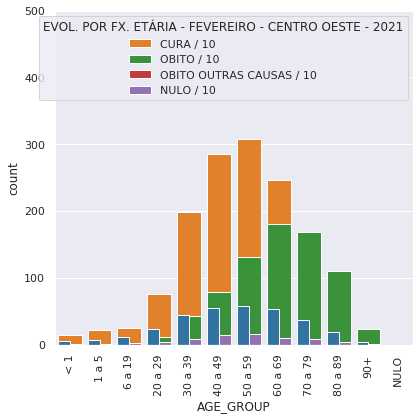

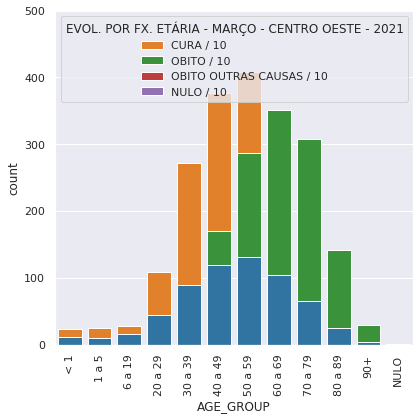

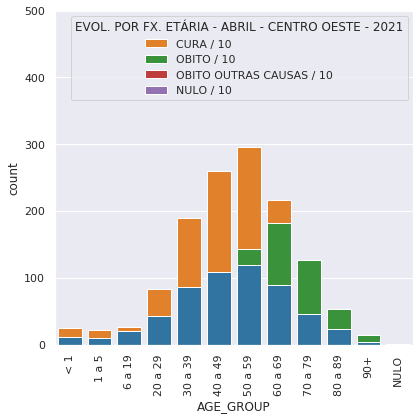

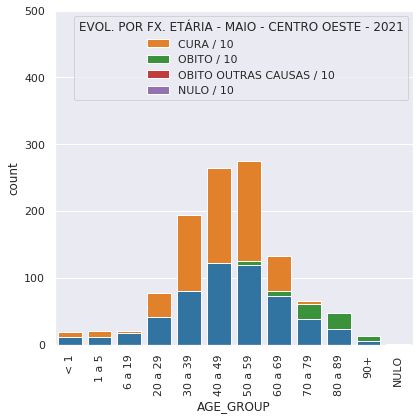

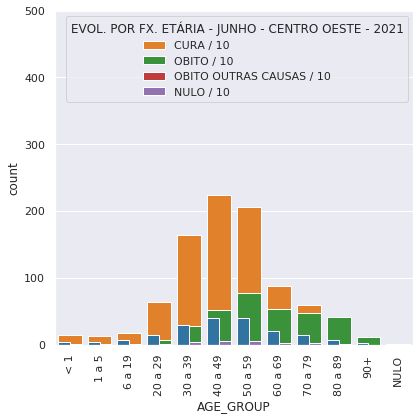

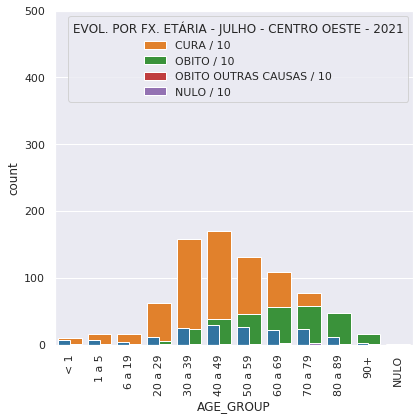

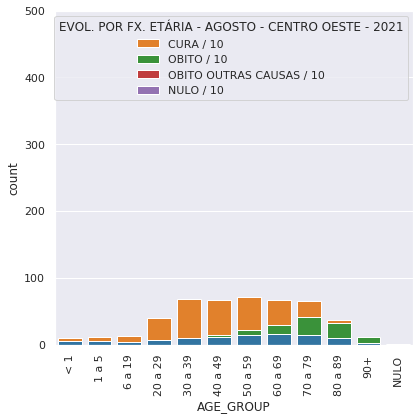

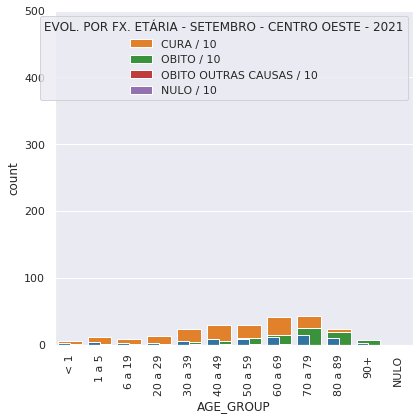

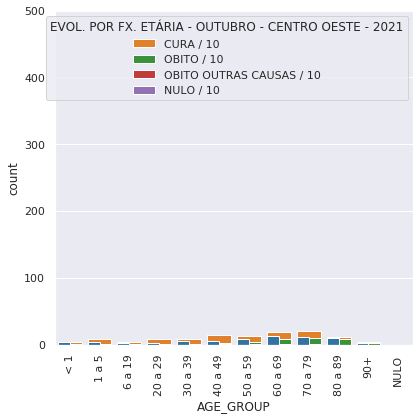

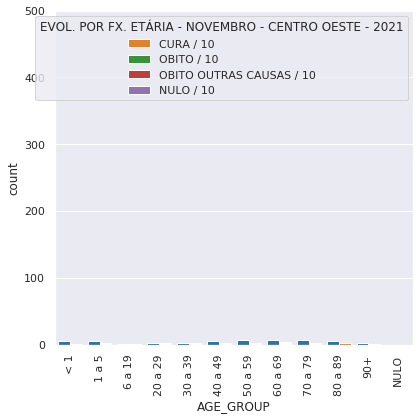

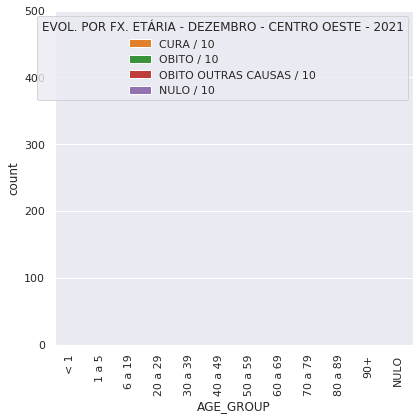

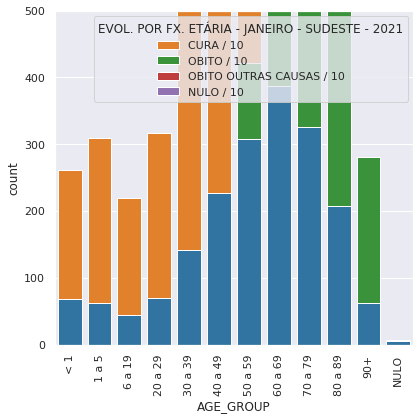

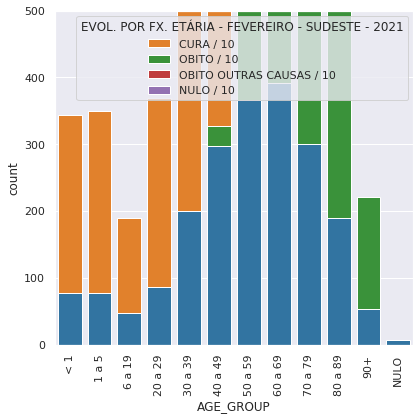

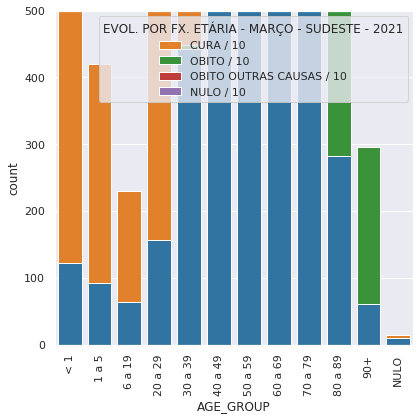

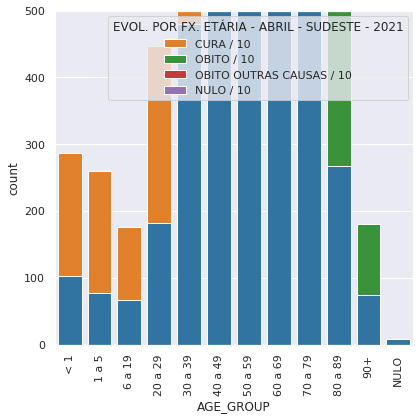

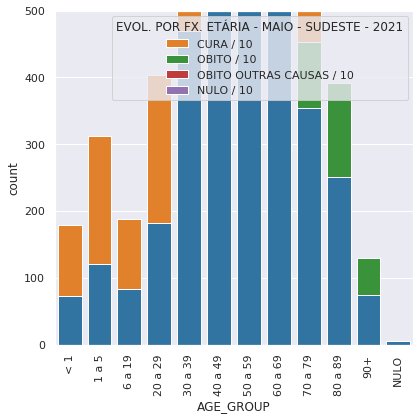

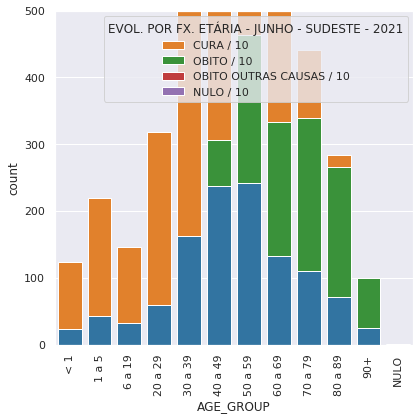

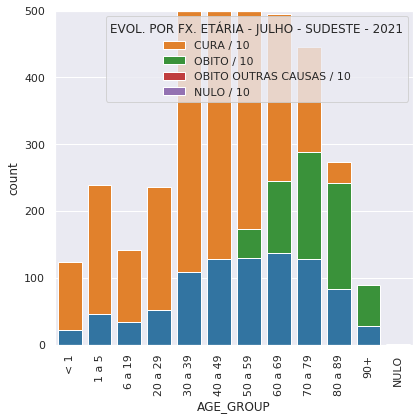

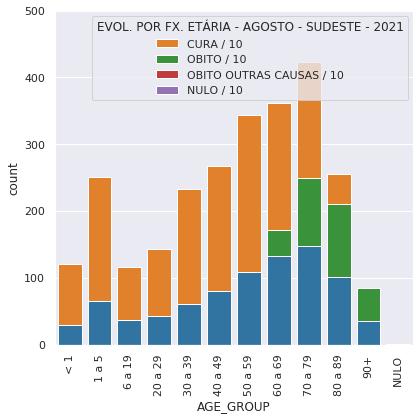

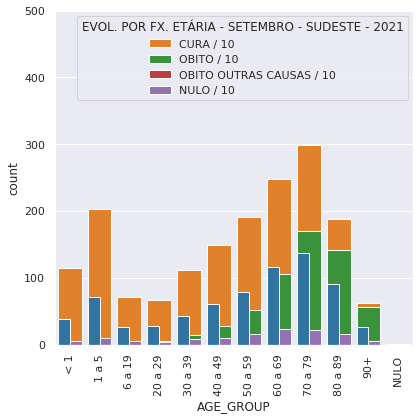

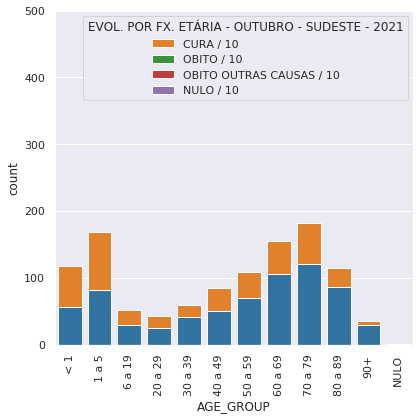

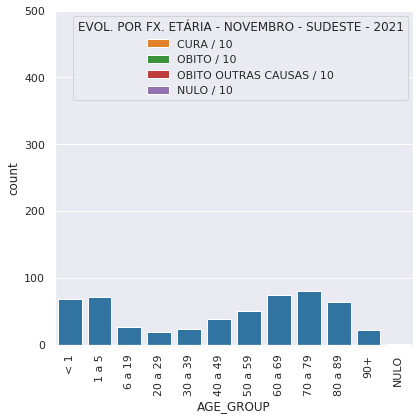

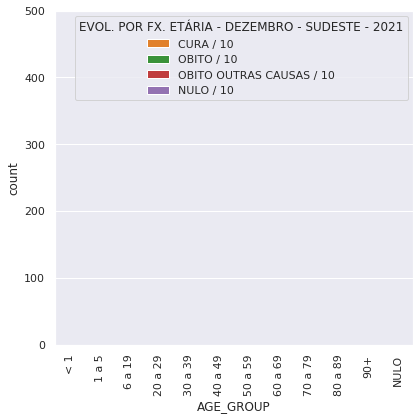

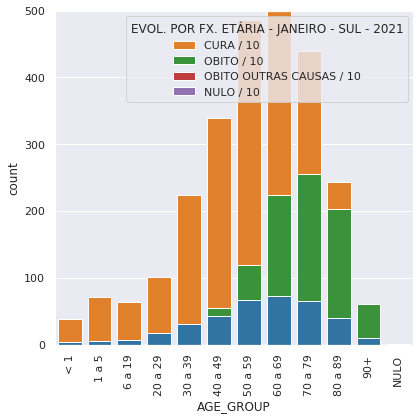

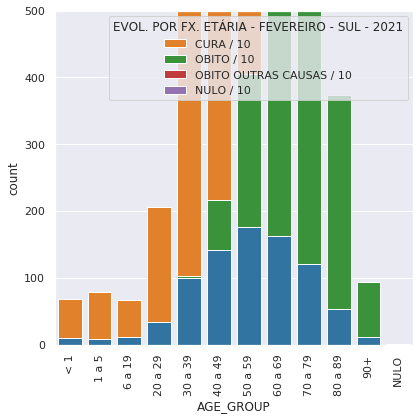

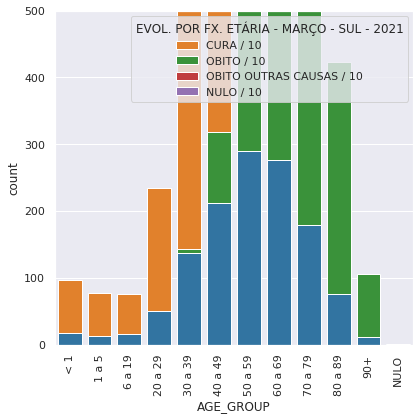

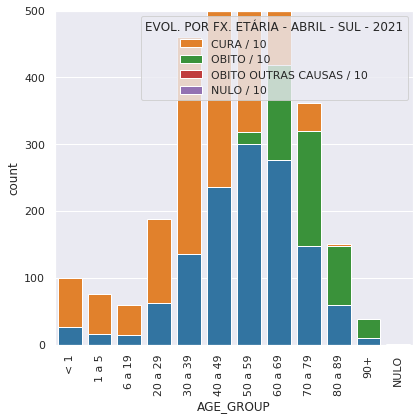

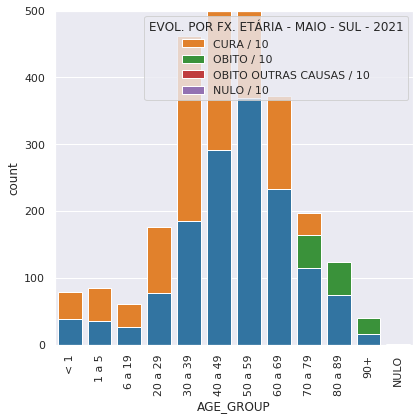

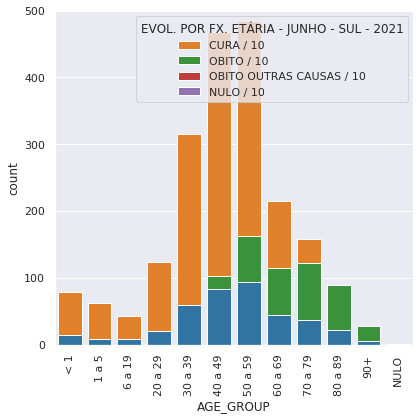

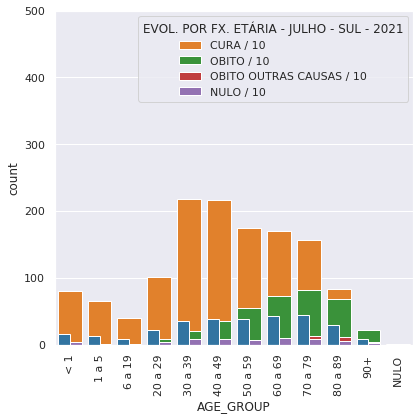

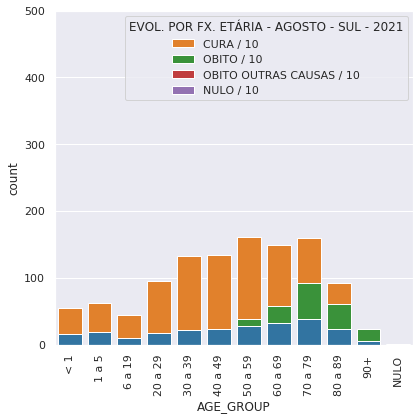

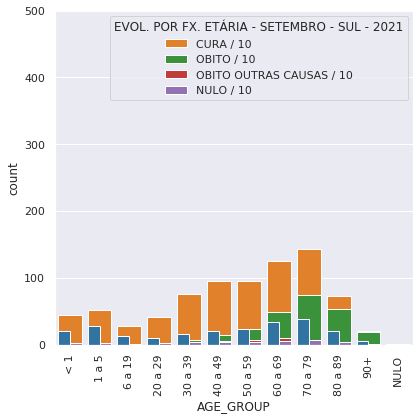

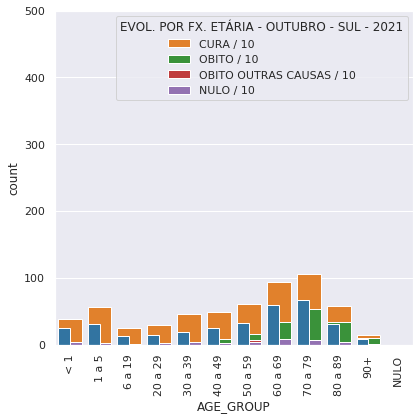

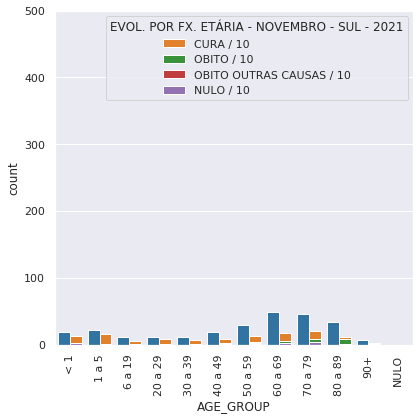

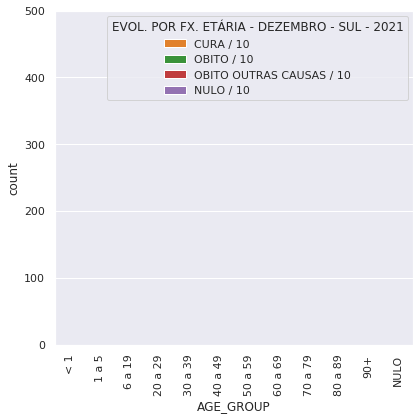

In [118]:
# set plot style: grey grid in the background:
sns.set(style="darkgrid")

for df in list(dfs.keys()):
    
    # mapping the months number (for indexing) and names for labels on plots
    months = {1:'JANEIRO', 2:'FEVEREIRO', 3:'MARÇO', 4:'ABRIL', 5:'MAIO', 6:'JUNHO',
              7:'JULHO', 8:'AGOSTO', 9:'SETEMBRO', 10:'OUTUBRO', 11:'NOVEMBRO', 12:'DEZEMBRO'}

    for month in list(months.keys()):

        # set the figure size
        plt.figure(figsize=(6, 6))
        
        # mapping the evolutions categories (for indexing) and names for labels on plots
        evolutions_cat = {'1': 'CURA', '2': 'ÓBITO', '3': 'ÓBITO OUT CAUSA', '9': 'IGNORADO', 'NULO': 'NULO'}
        
        # ---- # 
        
        # data slice for the first part of stacked bar (evolution category '1')
        data = dfs[df][1][(dfs[df][1]['month(DT_SIN_PRI)'] == month) & (dfs[df][1]['EVOLUCAO'] == '1')]
        
        # testing if the slice has at least 1 record to be plot, otherwise we create an artificial record with count 0.
        if len(data) == 0:
            data = empty
            data['count'] = 0
            data['EVOLUCAO'] = '1'
            data['month(DT_SIN_PRI)'] = month
        
        # making sure that all age group bars will be on plot
        data = complete_df_ag(month, '1', data)
        
        # seting an homogeneous scale dividing the number of cases by 10 (to ensure the bars do not explode the plot)
        data.loc[:,['count']] = data['count']/10
        
        # finally, the bar
        bar1 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, ci=None, palette=palette)
        
        # setting the label
        leg_bar1 = mpatches.Patch(color='darkblue', label='CURA')
        
        #setting the limit of y
        bar1.set(ylim=(0, 500))
        
        # ---- # 
        
        # data slice for the first part of stacked bar (evolution category '2')
        data = dfs[df][1][(dfs[df][1]['month(DT_SIN_PRI)'] == month) & (dfs[df][1]['EVOLUCAO'] == '2')]
        
        # testing if the slice has at least 1 record to be plot, otherwise we create an artificial record with count 0.
        if len(data) == 0:
            data = empty
            data['count'] = 0
            data['EVOLUCAO'] = '2'
            data['month(DT_SIN_PRI)'] = month
        
        # making sure that all age group bars will be on plot
        data = complete_df_ag(month, '2', data)
        
        # seting an homogeneous scale dividing the number of cases by 10 (to ensure the bars do not explode the plot)
        data.loc[:,['count']] = data['count']/10
        
        # finally, the bar
        bar2 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, estimator=sum, ci=None, palette=palette)
        
        # setting the label
        leg_bar2 = mpatches.Patch(color='darkblue' ,label='ÓBITO')
        
        #setting the limit of y
        bar2.set(ylim=(0, 500))
        
        # ---- #
        
        # we don't have category '3' on 2019 dataset, so: 
        if '2019' not in df:
            # data slice for the first part of stacked bar (evolution category '3')
            data = dfs[df][1][(dfs[df][1]['month(DT_SIN_PRI)'] == month) & (dfs[df][1]['EVOLUCAO'] == '3')]
            
            # testing if the slice has at least 1 record to be plot, otherwise we create an artificial record with count 0.
            if len(data) == 0:
                data = empty
                data['count'] = 0
                data['EVOLUCAO'] = '3'
                data['month(DT_SIN_PRI)'] = month
                
            # making sure that all age group bars will be on plot
            data = complete_df_ag(month, '3', data)
            
            # seting an homogeneous scale dividing the number of cases by 10 (to ensure the bars do not explode the plot)
            data.loc[:,['count']] = data['count']/10
            
            # finally, the bar
            bar3 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, estimator=sum, ci=None, palette=palette)
            
            # setting the label
            leg_bar3 = mpatches.Patch(color='darkblue', label='ÓBITO OUTRAS CAUSAS')
            
            #setting the limit of y
            bar3.set(ylim=(0, 500))
        
        # ---- # 
        
        # data slice for the first part of stacked bar (evolution category '1')
        data = dfs[df][1][(dfs[df][1]['month(DT_SIN_PRI)'] == month) & (dfs[df][1]['EVOLUCAO'] == '9')]
        
        # testing if the slice has at least 1 record to be plot, otherwise we create an artificial record with count 0.
        if len(data) == 0:
            data = empty
            data['count'] = 0
            data['EVOLUCAO'] = '9'
            data['month(DT_SIN_PRI)'] = month
            
        # making sure that all age group bars will be on plot
        data = complete_df_ag(month, '9', data)
        
        # seting an homogeneous scale dividing the number of cases by 10 (to ensure the bars do not explode the plot)
        data.loc[:,['count']] = data['count']/10
        
        # finally, the bar
        bar4 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, estimator=sum, ci=None, palette=palette)
        
        # setting the label
        leg_bar4 = mpatches.Patch(color='darkblue', label='IGNORADO')
        
        #setting the limit of y
        bar4.set(ylim=(0, 500))
        
        # ---- # 
        
        # data slice for the first part of stacked bar (evolution category '1')
        data = dfs[df][1][(dfs[df][1]['month(DT_SIN_PRI)'] == month) & (dfs[df][1]['EVOLUCAO'] == 'NULO')]
        
        # testing if the slice has at least 1 record to be plot, otherwise we create an artificial record with count 0.
        if len(data) == 0:
            data = empty
            data['count'] = 0
            data['EVOLUCAO'] = 'NULO'
            data['month(DT_SIN_PRI)'] = month
        
        # making sure that all age group bars will be on plot
        data = complete_df_ag(month, '9', data)
        
        # seting an homogeneous scale dividing the number of cases by 10 (to ensure the bars do not explode the plot)
        data.loc[:,['count']] = data['count']/10
        
        # finally, the bar
        bar5 = sns.barplot(x="AGE_GROUP", y="count", hue="EVOLUCAO", data=data, estimator=sum, ci=None, palette=palette)
        
        # setting the label
        leg_bar5 = mpatches.Patch(color='darkblue', label='NULO')
        
        #setting the limit of y
        bar5.set(ylim=(0, 500))

        plt.legend(title='EVOL. POR FX. ETÁRIA - ' + months[month] + ' - ' + dfs[df][0] + ' - ' + df[3:7], loc='upper right', labels=['CURA / 10', 'OBITO / 10', 'OBITO OUTRAS CAUSAS / 10', 'NULO / 10'])
        plt.xticks(rotation='vertical')
        plt.tight_layout()

<hr />
<hr />
<hr />

In [95]:
df = super_srag.select('CLASSI_FIN', 'SG_UF_NOT', 'DT_SIN_PRI').groupBy([F.year('DT_SIN_PRI'), F.month('DT_SIN_PRI'), 'SG_UF_NOT', 'CLASSI_FIN']).count().orderBy(['year(DT_SIN_PRI)', 'month(DT_SIN_PRI)', 'SG_UF_NOT', 'CLASSI_FIN']).repartition(32).cache()

# transforming integer columns into string to allow renaming None to 'NULO'
for col in df.columns:
    if col != 'count':
        df = df.withColumn(col, F.col(col).cast('string'))

df = df.fillna('NULO')

In [96]:
df = df.withColumnRenamed('month(DT_SIN_PRI)', 'month').withColumn('month', F.lpad(F.col('month'),2,'0'))
df = df.withColumnRenamed('year(DT_SIN_PRI)', 'year')

In [97]:
def month_year(month, year):
    return month + '-' + year
udf_month_year = F.udf(month_year, 'string')

In [98]:
df = df.withColumn('month_year', udf_month_year(F.col('month'), F.col('year')))

In [99]:
year_month_2019 = df.filter(F.col('year') == '2019').groupBy('month_year').count().orderBy('month_year').select('month_year').rdd.flatMap(lambda x: x).collect()
year_month_2020 = df.filter(F.col('year') == '2020').groupBy('month_year').count().orderBy('month_year').select('month_year').rdd.flatMap(lambda x: x).collect()
year_month_2021 = df.filter(F.col('year') == '2021').groupBy('month_year').count().orderBy('month_year').select('month_year').rdd.flatMap(lambda x: x).collect()

In [104]:
sem_1_2019 = year_month_2019[0:6]
sem_2_2019 = year_month_2019[6:]
sem_1_2020 = year_month_2020[0:6]
sem_2_2020 = year_month_2020[6:]
sem_1_2021 = year_month_2021[0:6]
sem_2_2021 = year_month_2021[6:]

semesters = {
    '1º SEM-2019': sem_1_2019,
    '2º SEM-2019': sem_2_2019,
    '1º SEM-2020': sem_1_2020,
    '2º SEM-2020': sem_2_2020,
    '1º SEM-2021': sem_1_2021
}

# to ensure the same shape
semesters['1º SEM-2021'].append('06-2021')

In [105]:
regions = {
    'NORTE': ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC'],
    'NORDESTE': ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA'],
    'CENTRO': ['MT', 'MS', 'GO'],
    'SUDESTE': ['SP', 'RJ', 'ES', 'MG'],
    'SUL': ['PR', 'RS', 'SC']
}

ValueError: operands could not be broadcast together with shapes (6,) (7,) 

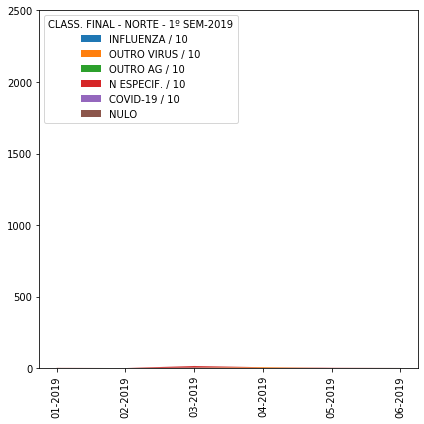

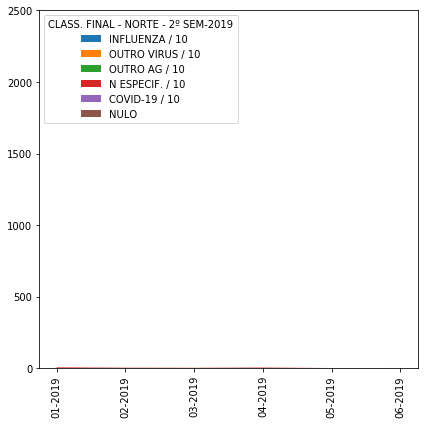

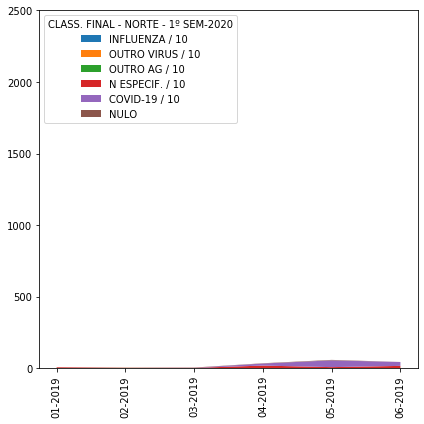

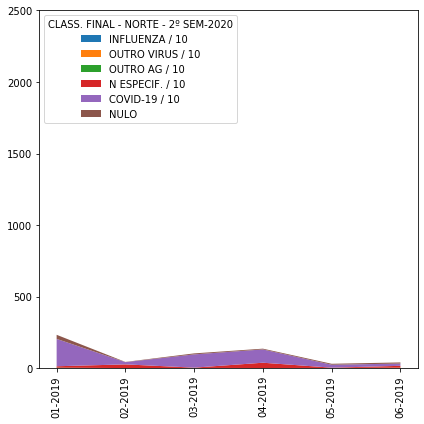

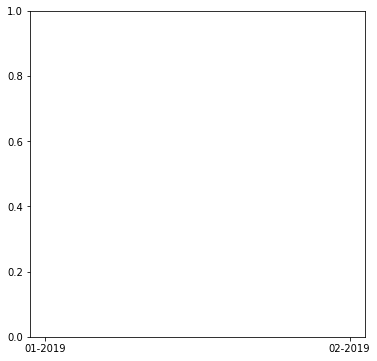

In [106]:
for region in list(regions.keys()):
#     print(region)
    for semester in list(semesters.keys()):
#         print(semester)
        y_1, y_2, y_3, y_4, y_5, y_null = [], [], [], [], [], []
        for my in semesters[semester]:
#             print(my)
            y_1_value = df.filter((F.col('month_year') == my) & (F.col('CLASSI_FIN') == '1') & (df.SG_UF_NOT.isin(regions[region]))).select('count').withColumn('count', F.col('count')/F.lit(10)).rdd.flatMap(lambda x: x).collect()
            if len(y_1_value) == 0:
                y_1.append(0)
            else:
                y_1.append(y_1_value[0])

            y_2_value = df.filter((F.col('month_year') == my) & (F.col('CLASSI_FIN') == '2') & (df.SG_UF_NOT.isin(regions[region]))).select('count').withColumn('count', F.col('count')/F.lit(10)).rdd.flatMap(lambda x: x).collect()
            if len(y_2_value) == 0:
                y_2.append(0)
            else:
                y_2.append(y_2_value[0])

            y_3_value = df.filter((F.col('month_year') == my) & (F.col('CLASSI_FIN') == '3') & (df.SG_UF_NOT.isin(regions[region]))).select('count').withColumn('count', F.col('count')/F.lit(10)).rdd.flatMap(lambda x: x).collect()
            if len(y_3_value) == 0:
                y_3.append(0)
            else:
                y_3.append(y_3_value[0])

            y_4_value = df.filter((F.col('month_year') == my) & (F.col('CLASSI_FIN') == '4') & (df.SG_UF_NOT.isin(regions[region]))).select('count').withColumn('count', F.col('count')/F.lit(10)).rdd.flatMap(lambda x: x).collect()
            if len(y_4_value) == 0:
                y_4.append(0)
            else:
                y_4.append(y_4_value[0])

            y_5_value = df.filter((F.col('month_year') == my) & (F.col('CLASSI_FIN') == '5') & (df.SG_UF_NOT.isin(regions[region]))).select('count').withColumn('count', F.col('count')/F.lit(10)).rdd.flatMap(lambda x: x).collect()
            if len(y_5_value) == 0:
                y_5.append(0)
            else:
                y_5.append(y_5_value[0])

            y_null_value = df.filter((F.col('month_year') == my) & (F.col('CLASSI_FIN') == 'NULO') & (df.SG_UF_NOT.isin(regions[region]))).select('count').withColumn('count', F.col('count')/F.lit(10)).rdd.flatMap(lambda x: x).collect()
            if len(y_null_value) == 0:
                y_null.append(0)
            else:
                y_null.append(y_null_value[0])

        # Basic stacked area chart.
        plt.figure(figsize=(6, 6))
        plt.stackplot(sem_1_2019, y_1, y_2, y_3, y_4, y_5, y_null, labels=['INFLUENZA / 10','OUTRO VIRUS / 10','OUTRO AG / 10', 'N ESPECIF. / 10', 'COVID-19 / 10', 'NULO'])
        plt.legend(loc='upper left', title='CLASS. FINAL - ' + region + ' - ' + semester)
        plt.ylim((0, 2500))
        plt.xticks(rotation='vertical')
        plt.tight_layout()

<hr />
<hr />
<hr />

In [24]:
# preparing the data
df = super_srag.select(F.month('DT_SIN_PRI'), F.year('DT_SIN_PRI'), 'SG_UF_NOT', 'epi_week_year',
                  'GMR_TRANSIT_STATIONS_AVG', 'GMR_GROCERY_AND_PHARMACY_AVG', 'GMR_RETAIL_AND_RECREATION_AVG', 'GMR_WORKPLACES_PERCENT_AVG', 'GMR_RESIDENTIAL_PERCENT_AVG', 'GMR_PARKS_PERCENT_AVG',
                  'INMET_TEMP_C_AVG', 'INMET_RELATIVE_AIR_HUMIDITY_AVG', 'INMET_DAILY_PRECIPT_AVG'                 
                 )

df = df.withColumnRenamed('month(DT_SIN_PRI)', 'month').withColumnRenamed('year(DT_SIN_PRI)', 'year')\
        .withColumn('month_year', udf_month_year(F.col('month').cast('string'), F.col('year').cast('string')))\
        .withColumn('month_year', F.lpad(F.col('month_year'), 7, '0'))

In [50]:
# year_month_2019 = df.filter(F.col('year') == '2019').groupBy('month_year').count().orderBy('month_year').select('month_year').rdd.flatMap(lambda x: x).collect()
year_month_2020 = df.filter(F.col('year') == '2020').groupBy('month_year').count().orderBy('month_year').select('month_year').rdd.flatMap(lambda x: x).collect()
year_month_2021 = df.filter(F.col('year') == '2021').groupBy('month_year').count().orderBy('month_year').select('month_year').rdd.flatMap(lambda x: x).collect()

In [52]:
# sem_1_2019 = year_month_2019[0:6]
# sem_2_2019 = year_month_2019[6:]
sem_1_2020 = year_month_2020[0:6]
sem_2_2020 = year_month_2020[6:]
sem_1_2021 = year_month_2021[0:6]
sem_2_2021 = year_month_2021[6:]

semesters = {
#     '1º SEM-2019': sem_1_2019,
#     '2º SEM-2019': sem_2_2019,
    '1st_SEM-2020': sem_1_2020,
    '2nd_SEM-2020': sem_2_2020,
    '1st_SEM-2021': sem_1_2021
}

# to ensure the same shape
semesters['1st_SEM-2021'].append('06-2021')

In [53]:
regions = {
    'NORTE': ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC'],
    'NORDESTE': ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA'],
    'CENTRO': ['MT', 'MS', 'GO'],
    'SUDESTE': ['SP', 'RJ', 'ES', 'MG'],
    'SUL': ['PR', 'RS', 'SC']
}

In [ ]:
for semester in list(semesters.keys()):
    for region in list(regions.keys()):
        df_ = df.filter((F.col('month_year').isin(semesters[semester])) & (F.col('SG_UF_NOT').isin(regions[region])))
        
        df_ = df_.groupBy('month_year').agg({'GMR_WORKPLACES_PERCENT_AVG':'avg',
                                       'GMR_RESIDENTIAL_PERCENT_AVG':'avg'})\
                                 .withColumnRenamed('avg(GMR_RESIDENTIAL_PERCENT_AVG)', 'GMR_RESID_PERC_AVG_NORDESTE')\
                                 .withColumnRenamed('avg(GMR_WORKPLACES_PERCENT_AVG)', 'GMR_WORKPLACES_PERCENT_AVG_NORDESTE')\
                                 .orderBy('month_year').toPandas()
        
        fig = go.Figure(layout_yaxis_range=[-50,50])

        fig.add_trace(go.Scatter(x=df_['month_year'].tolist(), y=df_['GMR_RESID_PERC_AVG_NORDESTE'].tolist(), name='resid. isolation avg',
                                 line=dict(color='green', width=4, shape='spline')))

        fig.add_trace(go.Scatter(x=df_['month_year'].tolist(), y=df_['GMR_WORKPLACES_PERCENT_AVG_NORDESTE'].tolist(), name='work frequence avg',
                                 line=dict(color='firebrick', width=4, shape='spline')))

        fig.add_trace(go.Scatter(x=df_['month_year'].tolist(), y=[0,0,0,0,0,0], name='baseline',
                                 line=dict(color='black', width=4, shape='spline')))

        fig.update_layout(title='Resid. isolation and Work Freq. - ' + semester + ' - ' + region,
                           xaxis_title='month',
                           yaxis_title='%'
                         )

        fig.update_layout(margin=dict(l=5, r=10, t=30, b=10),
                          width=600
                         )

        fig.write_image("plt_" + semester + "_" + region + ".png")